# Variational Autoencoder (VAE)
* Get reduced feature vectors (16-dimension) from monomer sequences (32-dimension) using VAE

### 1. Train VAE


In [1]:
# import
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from vae.encoder import Encoder
from vae.decoder import Decoder
from vae.train import train_model
from vae.utils.torch import FullyConnectedNeuralNetwork, TrainedVAE
from vae.utils.function import get_blockiness, plot_two_pairs_color_map

In [2]:
# prepare data
print("Data processing ...", flush=True)
# df_a = pd.read_csv('./data/dataSetA.csv', sep='  ', engine='python', header=None)
# df_b = pd.read_csv('./data/dataSetB.csv', sep='  ', engine='python', header=None)
df_c = pd.read_csv('./data/dataSetC.csv', sep='  ', engine='python', header=None)
# df_d = pd.read_csv('./data/dataSetD.csv', sep='  ', engine='python', header=None)

# df_total = pd.concat([df_a, df_b, df_c, df_d], axis=0)

df_total = df_c

# get volume fraction and blockiness
sequence_list = list()
for idx, row in df_total.iterrows():
    sequence = ''
    modified_row = row[1: -1]
    for num in modified_row:
        sequence += str(int(num))
    sequence_list.append(sequence)

df_total['sequence'] = sequence_list
df_total['0_fraction'] = df_total['sequence'].apply(lambda x: x.count('0') / 32.0)
df_total['1_fraction'] = df_total['sequence'].apply(lambda x: x.count('1') / 32.0)
df_total['blockiness'] = df_total['sequence'].apply(lambda x: get_blockiness(x))
df_total['interaction_parameter'] = df_total[0]
df_total['lamellar_period'] = df_total[33]
df_total = df_total.drop(labels=['sequence', 0, 33], axis=1)

Data processing ...


In [3]:
# prepare train / test dataset
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# preprocess sequence data
sequence_arr = df_total.iloc[:, :32].values.tolist()
x_data = torch.zeros(size=(len(sequence_arr), 32, 2), dtype=dtype, device=device)  # 32 (total) / only 2 beads
# x_data.fill_(value=1.0 / (1.0 + np.exp(1.0)))
for num in range(len(sequence_arr)):
    for idx in range(32):  # total 32 monomers
        if sequence_arr[num][idx] == 0:
            # x_data[num, idx, 0] = np.exp(1.0) / (1.0 + np.exp(1.0))  # soft max
            x_data[num, idx, 0] = 1.0
        else:
            # x_data[num, idx, 1] = np.exp(1.0) / (1.0 + np.exp(1.0))
            x_data[num, idx, 1] = 1.0

# preparation training data (target and features)
y_with_feature = df_total.iloc[:, 32:]

# set and fit the scalers
scaler_list = [StandardScaler() for _ in range(y_with_feature.shape[1])]
for idx, scaler in enumerate(scaler_list):
    scaler.fit(y_with_feature.iloc[:, idx].values.reshape(-1, 1))

x_train, x_test, y_with_feature_train, y_with_feature_test = train_test_split(x_data, y_with_feature, test_size=0.2)

y_with_feature_train = torch.tensor(y_with_feature_train.values, dtype=dtype, device=device)
y_with_feature_test = torch.tensor(y_with_feature_test.values, dtype=dtype, device=device)

In [4]:
# set encoder, decoder, and property network
encoder = Encoder(
    in_dimension=64,  # 32 * 2
    layer_1d=40,
    layer_2d=32,
    layer_3d=24,
    latent_dimension=16
).to(device)

decoder = Decoder(
    latent_dimension=16,
    gru_neurons_num=16,
    gru_stack_size=2,
    out_dimension=2  # bead 0 or 1
).to(device)

property_network = FullyConnectedNeuralNetwork(
    input_dim=16+4,  # latent dimension + feature dimension
    hidden_sizes=[8],
    output_dim=1
).to(device)

start training
num_epochs:  500
===== EPOCH 1 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.49it/s, property_loss=0.88, vae_loss=0.72]


Validation ...
Loss is 1.466
Elementary quality score is 53.024 / 100
Sequence quality score is 0.649 / 100
EPOCH 1 takes 0.043 minutes
===== EPOCH 2 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.82, vae_loss=0.72]


Validation ...
Loss is 1.306
Elementary quality score is 56.717 / 100
Sequence quality score is 0.000 / 100
EPOCH 2 takes 0.041 minutes
===== EPOCH 3 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.76it/s, property_loss=0.77, vae_loss=0.69]


Validation ...
Loss is 1.256
Elementary quality score is 58.036 / 100
Sequence quality score is 0.000 / 100
EPOCH 3 takes 0.041 minutes
===== EPOCH 4 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.45it/s, property_loss=0.62, vae_loss=0.68]


Validation ...
Loss is 1.158
Elementary quality score is 58.604 / 100
Sequence quality score is 0.000 / 100
EPOCH 4 takes 0.043 minutes
===== EPOCH 5 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.60, vae_loss=0.68]


Validation ...
Loss is 1.071
Elementary quality score is 58.665 / 100
Sequence quality score is 0.000 / 100
EPOCH 5 takes 0.042 minutes
===== EPOCH 6 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.48, vae_loss=0.68]


Validation ...
Loss is 1.038
Elementary quality score is 58.827 / 100
Sequence quality score is 0.000 / 100
EPOCH 6 takes 0.042 minutes
===== EPOCH 7 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.73it/s, property_loss=0.34, vae_loss=0.68]


Validation ...
Loss is 1.044
Elementary quality score is 57.468 / 100
Sequence quality score is 0.000 / 100
EPOCH 7 takes 0.041 minutes
===== EPOCH 8 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.19, vae_loss=0.68]


Validation ...
Loss is 0.965
Elementary quality score is 58.360 / 100
Sequence quality score is 0.649 / 100
EPOCH 8 takes 0.041 minutes
===== EPOCH 9 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.17, vae_loss=0.67]


Validation ...
Loss is 0.907
Elementary quality score is 59.963 / 100
Sequence quality score is 0.000 / 100
EPOCH 9 takes 0.042 minutes
===== EPOCH 10 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.18, vae_loss=0.67]


Validation ...
Loss is 0.909
Elementary quality score is 59.943 / 100
Sequence quality score is 0.000 / 100
EPOCH 10 takes 0.041 minutes
===== EPOCH 11 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.75it/s, property_loss=0.20, vae_loss=0.67]


Validation ...
Loss is 0.867
Elementary quality score is 59.963 / 100
Sequence quality score is 2.597 / 100
EPOCH 11 takes 0.041 minutes
===== EPOCH 12 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.12, vae_loss=0.66]


Validation ...
Loss is 0.870
Elementary quality score is 61.871 / 100
Sequence quality score is 0.000 / 100
EPOCH 12 takes 0.042 minutes
===== EPOCH 13 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.07, vae_loss=0.66]


Validation ...
Loss is 0.836
Elementary quality score is 61.181 / 100
Sequence quality score is 0.649 / 100
EPOCH 13 takes 0.041 minutes
===== EPOCH 14 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.65it/s, property_loss=0.13, vae_loss=0.65]


Validation ...
Loss is 0.866
Elementary quality score is 62.601 / 100
Sequence quality score is 0.649 / 100
EPOCH 14 takes 0.042 minutes
===== EPOCH 15 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.09, vae_loss=0.64]


Validation ...
Loss is 0.845
Elementary quality score is 62.926 / 100
Sequence quality score is 1.948 / 100
EPOCH 15 takes 0.041 minutes
===== EPOCH 16 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.08, vae_loss=0.64]


Validation ...
Loss is 0.804
Elementary quality score is 62.500 / 100
Sequence quality score is 3.247 / 100
EPOCH 16 takes 0.041 minutes
===== EPOCH 17 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.75it/s, property_loss=0.09, vae_loss=0.63]


Validation ...
Loss is 0.796
Elementary quality score is 62.662 / 100
Sequence quality score is 2.597 / 100
EPOCH 17 takes 0.041 minutes
===== EPOCH 18 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.07, vae_loss=0.65]


Validation ...
Loss is 0.788
Elementary quality score is 64.103 / 100
Sequence quality score is 2.597 / 100
EPOCH 18 takes 0.041 minutes
===== EPOCH 19 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.78it/s, property_loss=0.09, vae_loss=0.62]


Validation ...
Loss is 0.797
Elementary quality score is 63.494 / 100
Sequence quality score is 5.195 / 100
EPOCH 19 takes 0.041 minutes
===== EPOCH 20 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.09, vae_loss=0.62]


Validation ...
Loss is 0.792
Elementary quality score is 64.407 / 100
Sequence quality score is 1.948 / 100
EPOCH 20 takes 0.041 minutes
===== EPOCH 21 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.68it/s, property_loss=0.08, vae_loss=0.61]


Validation ...
Loss is 0.784
Elementary quality score is 63.920 / 100
Sequence quality score is 4.545 / 100
EPOCH 21 takes 0.042 minutes
===== EPOCH 22 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.69it/s, property_loss=0.08, vae_loss=0.62]


Validation ...
Loss is 0.784
Elementary quality score is 64.306 / 100
Sequence quality score is 3.896 / 100
EPOCH 22 takes 0.041 minutes
===== EPOCH 23 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.78it/s, property_loss=0.07, vae_loss=0.62]


Validation ...
Loss is 0.775
Elementary quality score is 64.773 / 100
Sequence quality score is 3.247 / 100
EPOCH 23 takes 0.041 minutes
===== EPOCH 24 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.05, vae_loss=0.63]


Validation ...
Loss is 0.785
Elementary quality score is 64.103 / 100
Sequence quality score is 3.896 / 100
EPOCH 24 takes 0.042 minutes
===== EPOCH 25 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.05, vae_loss=0.61]


Validation ...
Loss is 0.770
Elementary quality score is 64.793 / 100
Sequence quality score is 5.195 / 100
EPOCH 25 takes 0.041 minutes
===== EPOCH 26 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.07, vae_loss=0.62]


Validation ...
Loss is 0.777
Elementary quality score is 65.179 / 100
Sequence quality score is 3.896 / 100
EPOCH 26 takes 0.041 minutes
===== EPOCH 27 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.85it/s, property_loss=0.05, vae_loss=0.61]


Validation ...
Loss is 0.791
Elementary quality score is 64.671 / 100
Sequence quality score is 5.844 / 100
EPOCH 27 takes 0.047 minutes
===== EPOCH 28 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.48it/s, property_loss=0.04, vae_loss=0.61]


Validation ...
Loss is 0.767
Elementary quality score is 65.016 / 100
Sequence quality score is 5.195 / 100
EPOCH 28 takes 0.049 minutes
===== EPOCH 29 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.78it/s, property_loss=0.06, vae_loss=0.61]


Validation ...
Loss is 0.770
Elementary quality score is 65.808 / 100
Sequence quality score is 7.143 / 100
EPOCH 29 takes 0.047 minutes
===== EPOCH 30 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.71it/s, property_loss=0.06, vae_loss=0.61]


Validation ...
Loss is 0.777
Elementary quality score is 65.138 / 100
Sequence quality score is 2.597 / 100
EPOCH 30 takes 0.047 minutes
===== EPOCH 31 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.78it/s, property_loss=0.05, vae_loss=0.61]


Validation ...
Loss is 0.765
Elementary quality score is 65.260 / 100
Sequence quality score is 4.545 / 100
EPOCH 31 takes 0.047 minutes
===== EPOCH 32 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.80it/s, property_loss=0.04, vae_loss=0.61]


Validation ...
Loss is 0.780
Elementary quality score is 65.321 / 100
Sequence quality score is 4.545 / 100
EPOCH 32 takes 0.047 minutes
===== EPOCH 33 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.75it/s, property_loss=0.04, vae_loss=0.60]


Validation ...
Loss is 0.779
Elementary quality score is 65.645 / 100
Sequence quality score is 4.545 / 100
EPOCH 33 takes 0.047 minutes
===== EPOCH 34 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.77it/s, property_loss=0.04, vae_loss=0.60]


Validation ...
Loss is 0.770
Elementary quality score is 65.645 / 100
Sequence quality score is 6.494 / 100
EPOCH 34 takes 0.048 minutes
===== EPOCH 35 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.36it/s, property_loss=0.03, vae_loss=0.60]


Validation ...
Loss is 0.776
Elementary quality score is 65.808 / 100
Sequence quality score is 3.896 / 100
EPOCH 35 takes 0.050 minutes
===== EPOCH 36 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.81it/s, property_loss=0.04, vae_loss=0.60]


Validation ...
Loss is 0.771
Elementary quality score is 64.935 / 100
Sequence quality score is 3.896 / 100
EPOCH 36 takes 0.047 minutes
===== EPOCH 37 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.49it/s, property_loss=0.04, vae_loss=0.60]


Validation ...
Loss is 0.771
Elementary quality score is 65.625 / 100
Sequence quality score is 4.545 / 100
EPOCH 37 takes 0.050 minutes
===== EPOCH 38 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.81it/s, property_loss=0.03, vae_loss=0.60]


Validation ...
Loss is 0.767
Elementary quality score is 65.686 / 100
Sequence quality score is 3.896 / 100
EPOCH 38 takes 0.047 minutes
===== EPOCH 39 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.91it/s, property_loss=0.03, vae_loss=0.60]


Validation ...
Loss is 0.782
Elementary quality score is 65.524 / 100
Sequence quality score is 2.597 / 100
EPOCH 39 takes 0.046 minutes
===== EPOCH 40 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.19it/s, property_loss=0.04, vae_loss=0.60]


Validation ...
Loss is 0.765
Elementary quality score is 66.011 / 100
Sequence quality score is 5.844 / 100
EPOCH 40 takes 0.044 minutes
===== EPOCH 41 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.39it/s, property_loss=0.04, vae_loss=0.59]


Validation ...
Loss is 0.782
Elementary quality score is 66.031 / 100
Sequence quality score is 5.844 / 100
EPOCH 41 takes 0.050 minutes
===== EPOCH 42 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.40it/s, property_loss=0.03, vae_loss=0.59]


Validation ...
Loss is 0.767
Elementary quality score is 65.929 / 100
Sequence quality score is 7.792 / 100
EPOCH 42 takes 0.050 minutes
===== EPOCH 43 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.51it/s, property_loss=0.03, vae_loss=0.59]


Validation ...
Loss is 0.769
Elementary quality score is 66.295 / 100
Sequence quality score is 7.143 / 100
EPOCH 43 takes 0.050 minutes
===== EPOCH 44 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.02it/s, property_loss=0.03, vae_loss=0.59]


Validation ...
Loss is 0.773
Elementary quality score is 66.132 / 100
Sequence quality score is 5.195 / 100
EPOCH 44 takes 0.046 minutes
===== EPOCH 45 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.07it/s, property_loss=0.02, vae_loss=0.59]


Validation ...
Loss is 0.774
Elementary quality score is 65.869 / 100
Sequence quality score is 6.494 / 100
EPOCH 45 takes 0.045 minutes
===== EPOCH 46 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.41it/s, property_loss=0.03, vae_loss=0.58]


Validation ...
Loss is 0.772
Elementary quality score is 66.782 / 100
Sequence quality score is 6.494 / 100
EPOCH 46 takes 0.050 minutes
===== EPOCH 47 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.53it/s, property_loss=0.03, vae_loss=0.58]


Validation ...
Loss is 0.770
Elementary quality score is 66.315 / 100
Sequence quality score is 3.896 / 100
EPOCH 47 takes 0.049 minutes
===== EPOCH 48 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.63it/s, property_loss=0.02, vae_loss=0.59]


Validation ...
Loss is 0.784
Elementary quality score is 66.700 / 100
Sequence quality score is 7.143 / 100
EPOCH 48 takes 0.048 minutes
===== EPOCH 49 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.80it/s, property_loss=0.02, vae_loss=0.58]


Validation ...
Loss is 0.771
Elementary quality score is 66.579 / 100
Sequence quality score is 7.792 / 100
EPOCH 49 takes 0.047 minutes
===== EPOCH 50 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.50it/s, property_loss=0.02, vae_loss=0.58]


Validation ...
Loss is 0.785
Elementary quality score is 67.675 / 100
Sequence quality score is 9.740 / 100
EPOCH 50 takes 0.049 minutes
===== EPOCH 51 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.37it/s, property_loss=0.02, vae_loss=0.58]


Validation ...
Loss is 0.767
Elementary quality score is 66.903 / 100
Sequence quality score is 9.740 / 100
EPOCH 51 takes 0.050 minutes
===== EPOCH 52 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.70it/s, property_loss=0.02, vae_loss=0.57]


Validation ...
Loss is 0.772
Elementary quality score is 67.472 / 100
Sequence quality score is 5.844 / 100
EPOCH 52 takes 0.048 minutes
===== EPOCH 53 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.83it/s, property_loss=0.03, vae_loss=0.57]


Validation ...
Loss is 0.765
Elementary quality score is 67.918 / 100
Sequence quality score is 9.091 / 100
EPOCH 53 takes 0.047 minutes
===== EPOCH 54 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.48it/s, property_loss=0.02, vae_loss=0.57]


Validation ...
Loss is 0.759
Elementary quality score is 67.918 / 100
Sequence quality score is 3.896 / 100
EPOCH 54 takes 0.049 minutes
===== EPOCH 55 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.42it/s, property_loss=0.02, vae_loss=0.56]


Validation ...
Loss is 0.750
Elementary quality score is 68.060 / 100
Sequence quality score is 9.740 / 100
EPOCH 55 takes 0.050 minutes
===== EPOCH 56 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.47it/s, property_loss=0.01, vae_loss=0.56]


Validation ...
Loss is 0.768
Elementary quality score is 67.938 / 100
Sequence quality score is 8.442 / 100
EPOCH 56 takes 0.049 minutes
===== EPOCH 57 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.53it/s, property_loss=0.01, vae_loss=0.57]


Validation ...
Loss is 0.762
Elementary quality score is 68.243 / 100
Sequence quality score is 5.195 / 100
EPOCH 57 takes 0.049 minutes
===== EPOCH 58 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.65it/s, property_loss=0.01, vae_loss=0.56]


Validation ...
Loss is 0.749
Elementary quality score is 68.304 / 100
Sequence quality score is 7.792 / 100
EPOCH 58 takes 0.042 minutes
===== EPOCH 59 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.49it/s, property_loss=0.01, vae_loss=0.56]


Validation ...
Loss is 0.755
Elementary quality score is 69.399 / 100
Sequence quality score is 7.143 / 100
EPOCH 59 takes 0.043 minutes
===== EPOCH 60 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.01, vae_loss=0.55]


Validation ...
Loss is 0.749
Elementary quality score is 69.136 / 100
Sequence quality score is 6.494 / 100
EPOCH 60 takes 0.041 minutes
===== EPOCH 61 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.73it/s, property_loss=0.01, vae_loss=0.56]


Validation ...
Loss is 0.753
Elementary quality score is 69.359 / 100
Sequence quality score is 6.494 / 100
EPOCH 61 takes 0.041 minutes
===== EPOCH 62 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.01, vae_loss=0.55]


Validation ...
Loss is 0.747
Elementary quality score is 69.623 / 100
Sequence quality score is 5.195 / 100
EPOCH 62 takes 0.041 minutes
===== EPOCH 63 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.70it/s, property_loss=0.01, vae_loss=0.55]


Validation ...
Loss is 0.734
Elementary quality score is 69.724 / 100
Sequence quality score is 7.792 / 100
EPOCH 63 takes 0.048 minutes
===== EPOCH 64 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.66it/s, property_loss=0.02, vae_loss=0.55]


Validation ...
Loss is 0.742
Elementary quality score is 69.907 / 100
Sequence quality score is 5.195 / 100
EPOCH 64 takes 0.048 minutes
===== EPOCH 65 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.63it/s, property_loss=0.02, vae_loss=0.55]


Validation ...
Loss is 0.741
Elementary quality score is 69.866 / 100
Sequence quality score is 10.390 / 100
EPOCH 65 takes 0.048 minutes
===== EPOCH 66 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.45it/s, property_loss=0.02, vae_loss=0.55]


Validation ...
Loss is 0.730
Elementary quality score is 69.724 / 100
Sequence quality score is 4.545 / 100
EPOCH 66 takes 0.050 minutes
===== EPOCH 67 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.53it/s, property_loss=0.01, vae_loss=0.54]


Validation ...
Loss is 0.738
Elementary quality score is 70.901 / 100
Sequence quality score is 6.494 / 100
EPOCH 67 takes 0.049 minutes
===== EPOCH 68 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.59it/s, property_loss=0.01, vae_loss=0.54]


Validation ...
Loss is 0.729
Elementary quality score is 70.252 / 100
Sequence quality score is 7.792 / 100
EPOCH 68 takes 0.049 minutes
===== EPOCH 69 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.04it/s, property_loss=0.01, vae_loss=0.54]


Validation ...
Loss is 0.738
Elementary quality score is 70.049 / 100
Sequence quality score is 5.195 / 100
EPOCH 69 takes 0.046 minutes
===== EPOCH 70 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.94it/s, property_loss=0.01, vae_loss=0.54]


Validation ...
Loss is 0.738
Elementary quality score is 70.394 / 100
Sequence quality score is 3.896 / 100
EPOCH 70 takes 0.046 minutes
===== EPOCH 71 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.74it/s, property_loss=0.01, vae_loss=0.53]


Validation ...
Loss is 0.733
Elementary quality score is 70.292 / 100
Sequence quality score is 5.844 / 100
EPOCH 71 takes 0.047 minutes
===== EPOCH 72 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.40it/s, property_loss=0.01, vae_loss=0.53]


Validation ...
Loss is 0.742
Elementary quality score is 70.089 / 100
Sequence quality score is 1.299 / 100
EPOCH 72 takes 0.050 minutes
===== EPOCH 73 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.76it/s, property_loss=0.01, vae_loss=0.53]


Validation ...
Loss is 0.733
Elementary quality score is 70.942 / 100
Sequence quality score is 6.494 / 100
EPOCH 73 takes 0.047 minutes
===== EPOCH 74 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.63it/s, property_loss=0.02, vae_loss=0.54]


Validation ...
Loss is 0.739
Elementary quality score is 70.515 / 100
Sequence quality score is 7.792 / 100
EPOCH 74 takes 0.048 minutes
===== EPOCH 75 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.83it/s, property_loss=0.02, vae_loss=0.53]


Validation ...
Loss is 0.749
Elementary quality score is 70.657 / 100
Sequence quality score is 3.896 / 100
EPOCH 75 takes 0.047 minutes
===== EPOCH 76 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.68it/s, property_loss=0.01, vae_loss=0.53]


Validation ...
Loss is 0.735
Elementary quality score is 70.657 / 100
Sequence quality score is 7.143 / 100
EPOCH 76 takes 0.048 minutes
===== EPOCH 77 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.30it/s, property_loss=0.01, vae_loss=0.52]


Validation ...
Loss is 0.732
Elementary quality score is 70.718 / 100
Sequence quality score is 6.494 / 100
EPOCH 77 takes 0.051 minutes
===== EPOCH 78 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.67it/s, property_loss=0.01, vae_loss=0.53]


Validation ...
Loss is 0.741
Elementary quality score is 71.246 / 100
Sequence quality score is 9.091 / 100
EPOCH 78 takes 0.048 minutes
===== EPOCH 79 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.66it/s, property_loss=0.01, vae_loss=0.53]


Validation ...
Loss is 0.749
Elementary quality score is 70.982 / 100
Sequence quality score is 11.039 / 100
EPOCH 79 takes 0.048 minutes
===== EPOCH 80 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.61it/s, property_loss=0.01, vae_loss=0.53]


Validation ...
Loss is 0.744
Elementary quality score is 70.414 / 100
Sequence quality score is 10.390 / 100
EPOCH 80 takes 0.048 minutes
===== EPOCH 81 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.02it/s, property_loss=0.02, vae_loss=0.54]


Validation ...
Loss is 0.731
Elementary quality score is 70.739 / 100
Sequence quality score is 11.039 / 100
EPOCH 81 takes 0.046 minutes
===== EPOCH 82 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.43it/s, property_loss=0.02, vae_loss=0.52]


Validation ...
Loss is 0.737
Elementary quality score is 70.556 / 100
Sequence quality score is 7.792 / 100
EPOCH 82 takes 0.050 minutes
===== EPOCH 83 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.80it/s, property_loss=0.02, vae_loss=0.53]


Validation ...
Loss is 0.735
Elementary quality score is 70.617 / 100
Sequence quality score is 7.792 / 100
EPOCH 83 takes 0.047 minutes
===== EPOCH 84 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.90it/s, property_loss=0.02, vae_loss=0.53]


Validation ...
Loss is 0.732
Elementary quality score is 70.881 / 100
Sequence quality score is 8.442 / 100
EPOCH 84 takes 0.046 minutes
===== EPOCH 85 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.49it/s, property_loss=0.02, vae_loss=0.53]


Validation ...
Loss is 0.742
Elementary quality score is 71.043 / 100
Sequence quality score is 12.987 / 100
EPOCH 85 takes 0.050 minutes
===== EPOCH 86 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.73it/s, property_loss=0.01, vae_loss=0.53]


Validation ...
Loss is 0.749
Elementary quality score is 71.205 / 100
Sequence quality score is 11.039 / 100
EPOCH 86 takes 0.047 minutes
===== EPOCH 87 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.91it/s, property_loss=0.01, vae_loss=0.53]


Validation ...
Loss is 0.731
Elementary quality score is 70.962 / 100
Sequence quality score is 7.792 / 100
EPOCH 87 takes 0.046 minutes
===== EPOCH 88 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.72it/s, property_loss=0.01, vae_loss=0.52]


Validation ...
Loss is 0.729
Elementary quality score is 71.185 / 100
Sequence quality score is 7.143 / 100
EPOCH 88 takes 0.048 minutes
===== EPOCH 89 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.24it/s, property_loss=0.01, vae_loss=0.52]


Validation ...
Loss is 0.728
Elementary quality score is 71.510 / 100
Sequence quality score is 12.338 / 100
EPOCH 89 takes 0.052 minutes
===== EPOCH 90 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.49it/s, property_loss=0.01, vae_loss=0.52]


Validation ...
Loss is 0.733
Elementary quality score is 71.023 / 100
Sequence quality score is 11.039 / 100
EPOCH 90 takes 0.049 minutes
===== EPOCH 91 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.57it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.734
Elementary quality score is 71.875 / 100
Sequence quality score is 9.091 / 100
EPOCH 91 takes 0.049 minutes
===== EPOCH 92 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.99it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.737
Elementary quality score is 71.956 / 100
Sequence quality score is 12.338 / 100
EPOCH 92 takes 0.046 minutes
===== EPOCH 93 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.30it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.728
Elementary quality score is 72.565 / 100
Sequence quality score is 11.688 / 100
EPOCH 93 takes 0.051 minutes
===== EPOCH 94 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.50it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.738
Elementary quality score is 72.281 / 100
Sequence quality score is 13.636 / 100
EPOCH 94 takes 0.049 minutes
===== EPOCH 95 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.67it/s, property_loss=0.01, vae_loss=0.52]


Validation ...
Loss is 0.734
Elementary quality score is 71.834 / 100
Sequence quality score is 13.636 / 100
EPOCH 95 takes 0.048 minutes
===== EPOCH 96 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.54it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.734
Elementary quality score is 72.037 / 100
Sequence quality score is 18.182 / 100
EPOCH 96 takes 0.049 minutes
===== EPOCH 97 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.07it/s, property_loss=0.02, vae_loss=0.52]


Validation ...
Loss is 0.728
Elementary quality score is 71.692 / 100
Sequence quality score is 10.390 / 100
EPOCH 97 takes 0.053 minutes
===== EPOCH 98 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.40it/s, property_loss=0.03, vae_loss=0.52]


Validation ...
Loss is 0.731
Elementary quality score is 71.510 / 100
Sequence quality score is 10.390 / 100
EPOCH 98 takes 0.051 minutes
===== EPOCH 99 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.99it/s, property_loss=0.02, vae_loss=0.52]


Validation ...
Loss is 0.735
Elementary quality score is 71.733 / 100
Sequence quality score is 8.442 / 100
EPOCH 99 takes 0.046 minutes
===== EPOCH 100 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.89it/s, property_loss=0.01, vae_loss=0.52]


Validation ...
Loss is 0.728
Elementary quality score is 71.997 / 100
Sequence quality score is 7.792 / 100
EPOCH 100 takes 0.047 minutes
===== EPOCH 101 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.35it/s, property_loss=0.01, vae_loss=0.52]


Validation ...
Loss is 0.724
Elementary quality score is 71.936 / 100
Sequence quality score is 11.039 / 100
EPOCH 101 takes 0.050 minutes
===== EPOCH 102 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.64it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.722
Elementary quality score is 72.159 / 100
Sequence quality score is 7.792 / 100
EPOCH 102 takes 0.048 minutes
===== EPOCH 103 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.24it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.721
Elementary quality score is 72.281 / 100
Sequence quality score is 8.442 / 100
EPOCH 103 takes 0.051 minutes
===== EPOCH 104 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.733
Elementary quality score is 72.078 / 100
Sequence quality score is 14.935 / 100
EPOCH 104 takes 0.046 minutes
===== EPOCH 105 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.744
Elementary quality score is 71.794 / 100
Sequence quality score is 9.091 / 100
EPOCH 105 takes 0.047 minutes
===== EPOCH 106 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.61it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.739
Elementary quality score is 72.159 / 100
Sequence quality score is 14.286 / 100
EPOCH 106 takes 0.049 minutes
===== EPOCH 107 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.58it/s, property_loss=0.02, vae_loss=0.51]


Validation ...
Loss is 0.733
Elementary quality score is 71.956 / 100
Sequence quality score is 12.987 / 100
EPOCH 107 takes 0.049 minutes
===== EPOCH 108 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.94it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.731
Elementary quality score is 72.443 / 100
Sequence quality score is 11.688 / 100
EPOCH 108 takes 0.046 minutes
===== EPOCH 109 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.36it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.732
Elementary quality score is 72.626 / 100
Sequence quality score is 11.688 / 100
EPOCH 109 takes 0.050 minutes
===== EPOCH 110 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.19it/s, property_loss=0.02, vae_loss=0.50]


Validation ...
Loss is 0.739
Elementary quality score is 72.463 / 100
Sequence quality score is 11.039 / 100
EPOCH 110 takes 0.052 minutes
===== EPOCH 111 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.22it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.737
Elementary quality score is 72.342 / 100
Sequence quality score is 13.636 / 100
EPOCH 111 takes 0.052 minutes
===== EPOCH 112 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.48it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.732
Elementary quality score is 72.200 / 100
Sequence quality score is 7.792 / 100
EPOCH 112 takes 0.050 minutes
===== EPOCH 113 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.31it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.721
Elementary quality score is 72.484 / 100
Sequence quality score is 13.636 / 100
EPOCH 113 takes 0.051 minutes
===== EPOCH 114 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.46it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.724
Elementary quality score is 72.382 / 100
Sequence quality score is 10.390 / 100
EPOCH 114 takes 0.050 minutes
===== EPOCH 115 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.66it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.737
Elementary quality score is 72.240 / 100
Sequence quality score is 14.935 / 100
EPOCH 115 takes 0.048 minutes
===== EPOCH 116 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.23it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.732
Elementary quality score is 72.524 / 100
Sequence quality score is 9.740 / 100
EPOCH 116 takes 0.051 minutes
===== EPOCH 117 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.53it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.739
Elementary quality score is 72.504 / 100
Sequence quality score is 8.442 / 100
EPOCH 117 takes 0.049 minutes
===== EPOCH 118 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.82it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.732
Elementary quality score is 72.748 / 100
Sequence quality score is 11.688 / 100
EPOCH 118 takes 0.047 minutes
===== EPOCH 119 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.66it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.743
Elementary quality score is 72.565 / 100
Sequence quality score is 7.143 / 100
EPOCH 119 takes 0.048 minutes
===== EPOCH 120 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.35it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.749
Elementary quality score is 72.240 / 100
Sequence quality score is 12.338 / 100
EPOCH 120 takes 0.050 minutes
===== EPOCH 121 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.16it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.735
Elementary quality score is 72.545 / 100
Sequence quality score is 14.286 / 100
EPOCH 121 takes 0.052 minutes
===== EPOCH 122 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.55it/s, property_loss=0.02, vae_loss=0.50]


Validation ...
Loss is 0.730
Elementary quality score is 72.342 / 100
Sequence quality score is 12.987 / 100
EPOCH 122 takes 0.049 minutes
===== EPOCH 123 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.45it/s, property_loss=0.02, vae_loss=0.50]


Validation ...
Loss is 0.740
Elementary quality score is 72.321 / 100
Sequence quality score is 15.584 / 100
EPOCH 123 takes 0.050 minutes
===== EPOCH 124 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.66it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.743
Elementary quality score is 72.646 / 100
Sequence quality score is 11.688 / 100
EPOCH 124 takes 0.048 minutes
===== EPOCH 125 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.49it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.741
Elementary quality score is 72.423 / 100
Sequence quality score is 11.688 / 100
EPOCH 125 takes 0.050 minutes
===== EPOCH 126 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.95it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.739
Elementary quality score is 72.463 / 100
Sequence quality score is 8.442 / 100
EPOCH 126 takes 0.046 minutes
===== EPOCH 127 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.23it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.737
Elementary quality score is 72.585 / 100
Sequence quality score is 12.987 / 100
EPOCH 127 takes 0.044 minutes
===== EPOCH 128 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.82it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.741
Elementary quality score is 72.119 / 100
Sequence quality score is 11.688 / 100
EPOCH 128 takes 0.047 minutes
===== EPOCH 129 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.739
Elementary quality score is 72.463 / 100
Sequence quality score is 14.286 / 100
EPOCH 129 takes 0.046 minutes
===== EPOCH 130 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.51it/s, property_loss=0.00, vae_loss=0.50]


Validation ...
Loss is 0.747
Elementary quality score is 72.382 / 100
Sequence quality score is 7.143 / 100
EPOCH 130 takes 0.049 minutes
===== EPOCH 131 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.92it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.760
Elementary quality score is 72.098 / 100
Sequence quality score is 9.740 / 100
EPOCH 131 takes 0.046 minutes
===== EPOCH 132 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.45it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.748
Elementary quality score is 72.362 / 100
Sequence quality score is 14.286 / 100
EPOCH 132 takes 0.050 minutes
===== EPOCH 133 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.98it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.737
Elementary quality score is 72.484 / 100
Sequence quality score is 9.740 / 100
EPOCH 133 takes 0.046 minutes
===== EPOCH 134 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.48it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.742
Elementary quality score is 72.524 / 100
Sequence quality score is 11.688 / 100
EPOCH 134 takes 0.049 minutes
===== EPOCH 135 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.67it/s, property_loss=0.01, vae_loss=0.51]


Validation ...
Loss is 0.748
Elementary quality score is 72.524 / 100
Sequence quality score is 12.987 / 100
EPOCH 135 takes 0.048 minutes
===== EPOCH 136 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.33it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.750
Elementary quality score is 72.098 / 100
Sequence quality score is 6.494 / 100
EPOCH 136 takes 0.051 minutes
===== EPOCH 137 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.64it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.745
Elementary quality score is 72.463 / 100
Sequence quality score is 8.442 / 100
EPOCH 137 takes 0.048 minutes
===== EPOCH 138 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.69it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.738
Elementary quality score is 72.281 / 100
Sequence quality score is 11.039 / 100
EPOCH 138 takes 0.048 minutes
===== EPOCH 139 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.30it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.733
Elementary quality score is 72.443 / 100
Sequence quality score is 9.740 / 100
EPOCH 139 takes 0.051 minutes
===== EPOCH 140 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.68it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.741
Elementary quality score is 72.098 / 100
Sequence quality score is 14.935 / 100
EPOCH 140 takes 0.048 minutes
===== EPOCH 141 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.42it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.747
Elementary quality score is 72.545 / 100
Sequence quality score is 18.182 / 100
EPOCH 141 takes 0.050 minutes
===== EPOCH 142 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.66it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.755
Elementary quality score is 71.936 / 100
Sequence quality score is 14.935 / 100
EPOCH 142 takes 0.048 minutes
===== EPOCH 143 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.72it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.761
Elementary quality score is 71.997 / 100
Sequence quality score is 11.039 / 100
EPOCH 143 takes 0.048 minutes
===== EPOCH 144 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.72it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.762
Elementary quality score is 72.565 / 100
Sequence quality score is 12.338 / 100
EPOCH 144 takes 0.048 minutes
===== EPOCH 145 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.04it/s, property_loss=0.00, vae_loss=0.50]


Validation ...
Loss is 0.754
Elementary quality score is 72.342 / 100
Sequence quality score is 7.792 / 100
EPOCH 145 takes 0.046 minutes
===== EPOCH 146 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.07it/s, property_loss=0.00, vae_loss=0.49]


Validation ...
Loss is 0.754
Elementary quality score is 72.159 / 100
Sequence quality score is 11.039 / 100
EPOCH 146 takes 0.045 minutes
===== EPOCH 147 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.02, vae_loss=0.49]


Validation ...
Loss is 0.745
Elementary quality score is 72.545 / 100
Sequence quality score is 10.390 / 100
EPOCH 147 takes 0.047 minutes
===== EPOCH 148 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.52it/s, property_loss=0.02, vae_loss=0.49]


Validation ...
Loss is 0.751
Elementary quality score is 72.301 / 100
Sequence quality score is 9.740 / 100
EPOCH 148 takes 0.049 minutes
===== EPOCH 149 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.60it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.755
Elementary quality score is 72.484 / 100
Sequence quality score is 15.584 / 100
EPOCH 149 takes 0.049 minutes
===== EPOCH 150 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.82it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.761
Elementary quality score is 71.834 / 100
Sequence quality score is 9.091 / 100
EPOCH 150 takes 0.047 minutes
===== EPOCH 151 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.32it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.753
Elementary quality score is 72.687 / 100
Sequence quality score is 14.935 / 100
EPOCH 151 takes 0.051 minutes
===== EPOCH 152 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.43it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.743
Elementary quality score is 72.443 / 100
Sequence quality score is 11.688 / 100
EPOCH 152 takes 0.050 minutes
===== EPOCH 153 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.72it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.761
Elementary quality score is 72.362 / 100
Sequence quality score is 15.584 / 100
EPOCH 153 takes 0.048 minutes
===== EPOCH 154 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.45it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.761
Elementary quality score is 72.443 / 100
Sequence quality score is 12.338 / 100
EPOCH 154 takes 0.050 minutes
===== EPOCH 155 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.79it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.771
Elementary quality score is 72.078 / 100
Sequence quality score is 12.987 / 100
EPOCH 155 takes 0.047 minutes
===== EPOCH 156 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.33it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.755
Elementary quality score is 72.179 / 100
Sequence quality score is 11.688 / 100
EPOCH 156 takes 0.051 minutes
===== EPOCH 157 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.53it/s, property_loss=0.02, vae_loss=0.48]


Validation ...
Loss is 0.749
Elementary quality score is 72.058 / 100
Sequence quality score is 11.039 / 100
EPOCH 157 takes 0.049 minutes
===== EPOCH 158 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.45it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.748
Elementary quality score is 72.119 / 100
Sequence quality score is 12.338 / 100
EPOCH 158 takes 0.050 minutes
===== EPOCH 159 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.60it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.760
Elementary quality score is 72.058 / 100
Sequence quality score is 13.636 / 100
EPOCH 159 takes 0.049 minutes
===== EPOCH 160 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.05it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.767
Elementary quality score is 72.078 / 100
Sequence quality score is 12.987 / 100
EPOCH 160 takes 0.045 minutes
===== EPOCH 161 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.81it/s, property_loss=0.00, vae_loss=0.49]


Validation ...
Loss is 0.763
Elementary quality score is 72.200 / 100
Sequence quality score is 12.338 / 100
EPOCH 161 takes 0.047 minutes
===== EPOCH 162 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.91it/s, property_loss=0.00, vae_loss=0.50]


Validation ...
Loss is 0.756
Elementary quality score is 71.976 / 100
Sequence quality score is 12.987 / 100
EPOCH 162 takes 0.046 minutes
===== EPOCH 163 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.31it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.758
Elementary quality score is 71.774 / 100
Sequence quality score is 10.390 / 100
EPOCH 163 takes 0.051 minutes
===== EPOCH 164 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.20it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.763
Elementary quality score is 72.058 / 100
Sequence quality score is 11.688 / 100
EPOCH 164 takes 0.052 minutes
===== EPOCH 165 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.80it/s, property_loss=0.01, vae_loss=0.50]


Validation ...
Loss is 0.763
Elementary quality score is 72.200 / 100
Sequence quality score is 11.688 / 100
EPOCH 165 takes 0.047 minutes
===== EPOCH 166 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.94it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.767
Elementary quality score is 71.692 / 100
Sequence quality score is 12.987 / 100
EPOCH 166 takes 0.046 minutes
===== EPOCH 167 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.89it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.764
Elementary quality score is 72.504 / 100
Sequence quality score is 12.338 / 100
EPOCH 167 takes 0.046 minutes
===== EPOCH 168 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.56it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.761
Elementary quality score is 72.808 / 100
Sequence quality score is 12.987 / 100
EPOCH 168 takes 0.049 minutes
===== EPOCH 169 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.59it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.770
Elementary quality score is 72.342 / 100
Sequence quality score is 12.338 / 100
EPOCH 169 takes 0.049 minutes
===== EPOCH 170 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.83it/s, property_loss=0.00, vae_loss=0.48]


Validation ...
Loss is 0.771
Elementary quality score is 72.606 / 100
Sequence quality score is 11.688 / 100
EPOCH 170 takes 0.047 minutes
===== EPOCH 171 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.90it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.755
Elementary quality score is 72.585 / 100
Sequence quality score is 15.584 / 100
EPOCH 171 takes 0.046 minutes
===== EPOCH 172 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.09it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.764
Elementary quality score is 72.606 / 100
Sequence quality score is 16.883 / 100
EPOCH 172 takes 0.045 minutes
===== EPOCH 173 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.83it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.761
Elementary quality score is 72.808 / 100
Sequence quality score is 14.935 / 100
EPOCH 173 takes 0.047 minutes
===== EPOCH 174 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.83it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.775
Elementary quality score is 72.524 / 100
Sequence quality score is 9.740 / 100
EPOCH 174 takes 0.047 minutes
===== EPOCH 175 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.61it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.773
Elementary quality score is 72.220 / 100
Sequence quality score is 8.442 / 100
EPOCH 175 takes 0.048 minutes
===== EPOCH 176 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.83it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.784
Elementary quality score is 72.240 / 100
Sequence quality score is 15.584 / 100
EPOCH 176 takes 0.047 minutes
===== EPOCH 177 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.65it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.779
Elementary quality score is 72.179 / 100
Sequence quality score is 9.740 / 100
EPOCH 177 takes 0.048 minutes
===== EPOCH 178 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.04it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.768
Elementary quality score is 72.748 / 100
Sequence quality score is 9.740 / 100
EPOCH 178 takes 0.045 minutes
===== EPOCH 179 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.93it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.765
Elementary quality score is 72.342 / 100
Sequence quality score is 11.039 / 100
EPOCH 179 takes 0.046 minutes
===== EPOCH 180 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.60it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.769
Elementary quality score is 72.362 / 100
Sequence quality score is 11.688 / 100
EPOCH 180 takes 0.048 minutes
===== EPOCH 181 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.78it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.791
Elementary quality score is 72.159 / 100
Sequence quality score is 8.442 / 100
EPOCH 181 takes 0.047 minutes
===== EPOCH 182 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.50it/s, property_loss=0.00, vae_loss=0.48]


Validation ...
Loss is 0.789
Elementary quality score is 72.139 / 100
Sequence quality score is 11.039 / 100
EPOCH 182 takes 0.049 minutes
===== EPOCH 183 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.94it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.784
Elementary quality score is 72.504 / 100
Sequence quality score is 12.987 / 100
EPOCH 183 takes 0.046 minutes
===== EPOCH 184 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.10it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.791
Elementary quality score is 72.362 / 100
Sequence quality score is 13.636 / 100
EPOCH 184 takes 0.045 minutes
===== EPOCH 185 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.97it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.780
Elementary quality score is 72.524 / 100
Sequence quality score is 12.987 / 100
EPOCH 185 takes 0.046 minutes
===== EPOCH 186 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.90it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.767
Elementary quality score is 72.362 / 100
Sequence quality score is 11.039 / 100
EPOCH 186 takes 0.046 minutes
===== EPOCH 187 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.48it/s, property_loss=0.02, vae_loss=0.47]


Validation ...
Loss is 0.763
Elementary quality score is 72.687 / 100
Sequence quality score is 11.688 / 100
EPOCH 187 takes 0.049 minutes
===== EPOCH 188 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.05it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.763
Elementary quality score is 72.240 / 100
Sequence quality score is 11.039 / 100
EPOCH 188 takes 0.046 minutes
===== EPOCH 189 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.50it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.775
Elementary quality score is 71.895 / 100
Sequence quality score is 12.987 / 100
EPOCH 189 takes 0.049 minutes
===== EPOCH 190 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.81it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.776
Elementary quality score is 72.261 / 100
Sequence quality score is 9.740 / 100
EPOCH 190 takes 0.047 minutes
===== EPOCH 191 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.49it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.785
Elementary quality score is 72.159 / 100
Sequence quality score is 7.143 / 100
EPOCH 191 takes 0.049 minutes
===== EPOCH 192 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.55it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.788
Elementary quality score is 72.220 / 100
Sequence quality score is 10.390 / 100
EPOCH 192 takes 0.049 minutes
===== EPOCH 193 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.92it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.779
Elementary quality score is 72.504 / 100
Sequence quality score is 12.338 / 100
EPOCH 193 takes 0.046 minutes
===== EPOCH 194 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.29it/s, property_loss=0.00, vae_loss=0.48]


Validation ...
Loss is 0.783
Elementary quality score is 72.179 / 100
Sequence quality score is 14.935 / 100
EPOCH 194 takes 0.051 minutes
===== EPOCH 195 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.97it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.774
Elementary quality score is 72.930 / 100
Sequence quality score is 15.584 / 100
EPOCH 195 takes 0.046 minutes
===== EPOCH 196 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.99it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.787
Elementary quality score is 72.565 / 100
Sequence quality score is 12.987 / 100
EPOCH 196 takes 0.046 minutes
===== EPOCH 197 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.88it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.799
Elementary quality score is 71.936 / 100
Sequence quality score is 11.688 / 100
EPOCH 197 takes 0.046 minutes
===== EPOCH 198 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.84it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.788
Elementary quality score is 72.220 / 100
Sequence quality score is 9.740 / 100
EPOCH 198 takes 0.047 minutes
===== EPOCH 199 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.67it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.796
Elementary quality score is 71.814 / 100
Sequence quality score is 14.935 / 100
EPOCH 199 takes 0.048 minutes
===== EPOCH 200 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.06it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.793
Elementary quality score is 72.240 / 100
Sequence quality score is 9.091 / 100
EPOCH 200 takes 0.045 minutes
===== EPOCH 201 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.51it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.792
Elementary quality score is 72.098 / 100
Sequence quality score is 12.338 / 100
EPOCH 201 takes 0.049 minutes
===== EPOCH 202 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.51it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.783
Elementary quality score is 72.463 / 100
Sequence quality score is 7.792 / 100
EPOCH 202 takes 0.050 minutes
===== EPOCH 203 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.68it/s, property_loss=0.01, vae_loss=0.49]


Validation ...
Loss is 0.784
Elementary quality score is 72.301 / 100
Sequence quality score is 12.987 / 100
EPOCH 203 takes 0.048 minutes
===== EPOCH 204 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.43it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.792
Elementary quality score is 72.321 / 100
Sequence quality score is 9.091 / 100
EPOCH 204 takes 0.050 minutes
===== EPOCH 205 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.63it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.786
Elementary quality score is 72.524 / 100
Sequence quality score is 12.987 / 100
EPOCH 205 takes 0.048 minutes
===== EPOCH 206 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.88it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.780
Elementary quality score is 72.463 / 100
Sequence quality score is 9.740 / 100
EPOCH 206 takes 0.047 minutes
===== EPOCH 207 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.78it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.780
Elementary quality score is 72.707 / 100
Sequence quality score is 12.338 / 100
EPOCH 207 takes 0.047 minutes
===== EPOCH 208 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.88it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.782
Elementary quality score is 72.646 / 100
Sequence quality score is 12.338 / 100
EPOCH 208 takes 0.046 minutes
===== EPOCH 209 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.77it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.789
Elementary quality score is 72.220 / 100
Sequence quality score is 13.636 / 100
EPOCH 209 takes 0.047 minutes
===== EPOCH 210 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.00, vae_loss=0.48]


Validation ...
Loss is 0.785
Elementary quality score is 72.545 / 100
Sequence quality score is 14.935 / 100
EPOCH 210 takes 0.047 minutes
===== EPOCH 211 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.82it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.797
Elementary quality score is 72.078 / 100
Sequence quality score is 9.091 / 100
EPOCH 211 takes 0.047 minutes
===== EPOCH 212 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.64it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.798
Elementary quality score is 72.849 / 100
Sequence quality score is 14.935 / 100
EPOCH 212 takes 0.048 minutes
===== EPOCH 213 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.60it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.805
Elementary quality score is 72.768 / 100
Sequence quality score is 9.740 / 100
EPOCH 213 takes 0.049 minutes
===== EPOCH 214 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.91it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.795
Elementary quality score is 72.829 / 100
Sequence quality score is 7.143 / 100
EPOCH 214 takes 0.046 minutes
===== EPOCH 215 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.88it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.797
Elementary quality score is 72.585 / 100
Sequence quality score is 9.740 / 100
EPOCH 215 takes 0.047 minutes
===== EPOCH 216 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.42it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.804
Elementary quality score is 72.342 / 100
Sequence quality score is 9.740 / 100
EPOCH 216 takes 0.050 minutes
===== EPOCH 217 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.67it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.801
Elementary quality score is 72.443 / 100
Sequence quality score is 8.442 / 100
EPOCH 217 takes 0.048 minutes
===== EPOCH 218 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.04it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.796
Elementary quality score is 72.768 / 100
Sequence quality score is 12.987 / 100
EPOCH 218 takes 0.046 minutes
===== EPOCH 219 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.68it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.810
Elementary quality score is 72.403 / 100
Sequence quality score is 10.390 / 100
EPOCH 219 takes 0.042 minutes
===== EPOCH 220 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.64it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.783
Elementary quality score is 72.403 / 100
Sequence quality score is 12.987 / 100
EPOCH 220 takes 0.042 minutes
===== EPOCH 221 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.74it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.788
Elementary quality score is 72.687 / 100
Sequence quality score is 11.039 / 100
EPOCH 221 takes 0.041 minutes
===== EPOCH 222 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.800
Elementary quality score is 72.585 / 100
Sequence quality score is 14.286 / 100
EPOCH 222 takes 0.042 minutes
===== EPOCH 223 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.805
Elementary quality score is 72.687 / 100
Sequence quality score is 11.039 / 100
EPOCH 223 takes 0.041 minutes
===== EPOCH 224 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.800
Elementary quality score is 72.788 / 100
Sequence quality score is 7.143 / 100
EPOCH 224 takes 0.041 minutes
===== EPOCH 225 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.73it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.800
Elementary quality score is 72.382 / 100
Sequence quality score is 11.688 / 100
EPOCH 225 takes 0.041 minutes
===== EPOCH 226 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.60it/s, property_loss=0.02, vae_loss=0.46]


Validation ...
Loss is 0.808
Elementary quality score is 72.463 / 100
Sequence quality score is 14.935 / 100
EPOCH 226 takes 0.042 minutes
===== EPOCH 227 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.22it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.809
Elementary quality score is 72.098 / 100
Sequence quality score is 11.688 / 100
EPOCH 227 takes 0.044 minutes
===== EPOCH 228 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.47it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.807
Elementary quality score is 72.443 / 100
Sequence quality score is 8.442 / 100
EPOCH 228 takes 0.043 minutes
===== EPOCH 229 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.43it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.804
Elementary quality score is 72.119 / 100
Sequence quality score is 9.740 / 100
EPOCH 229 takes 0.043 minutes
===== EPOCH 230 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.57it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.802
Elementary quality score is 72.139 / 100
Sequence quality score is 9.091 / 100
EPOCH 230 takes 0.042 minutes
===== EPOCH 231 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.69it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.806
Elementary quality score is 72.443 / 100
Sequence quality score is 7.143 / 100
EPOCH 231 takes 0.041 minutes
===== EPOCH 232 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.64it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.817
Elementary quality score is 72.545 / 100
Sequence quality score is 11.688 / 100
EPOCH 232 takes 0.042 minutes
===== EPOCH 233 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.77it/s, property_loss=0.00, vae_loss=0.49]


Validation ...
Loss is 0.820
Elementary quality score is 72.585 / 100
Sequence quality score is 11.039 / 100
EPOCH 233 takes 0.041 minutes
===== EPOCH 234 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.60it/s, property_loss=0.01, vae_loss=0.48]


Validation ...
Loss is 0.813
Elementary quality score is 72.748 / 100
Sequence quality score is 15.584 / 100
EPOCH 234 takes 0.042 minutes
===== EPOCH 235 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.69it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.812
Elementary quality score is 72.545 / 100
Sequence quality score is 11.039 / 100
EPOCH 235 takes 0.041 minutes
===== EPOCH 236 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.789
Elementary quality score is 72.808 / 100
Sequence quality score is 14.286 / 100
EPOCH 236 takes 0.041 minutes
===== EPOCH 237 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.61it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.796
Elementary quality score is 72.545 / 100
Sequence quality score is 7.792 / 100
EPOCH 237 takes 0.042 minutes
===== EPOCH 238 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.65it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.783
Elementary quality score is 72.829 / 100
Sequence quality score is 9.091 / 100
EPOCH 238 takes 0.042 minutes
===== EPOCH 239 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.792
Elementary quality score is 73.032 / 100
Sequence quality score is 9.740 / 100
EPOCH 239 takes 0.041 minutes
===== EPOCH 240 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.63it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.810
Elementary quality score is 72.626 / 100
Sequence quality score is 7.792 / 100
EPOCH 240 takes 0.042 minutes
===== EPOCH 241 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.815
Elementary quality score is 72.443 / 100
Sequence quality score is 11.688 / 100
EPOCH 241 takes 0.042 minutes
===== EPOCH 242 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.69it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.831
Elementary quality score is 72.017 / 100
Sequence quality score is 10.390 / 100
EPOCH 242 takes 0.042 minutes
===== EPOCH 243 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.73it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.828
Elementary quality score is 72.362 / 100
Sequence quality score is 10.390 / 100
EPOCH 243 takes 0.041 minutes
===== EPOCH 244 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.65it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.814
Elementary quality score is 72.585 / 100
Sequence quality score is 10.390 / 100
EPOCH 244 takes 0.042 minutes
===== EPOCH 245 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.58it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.815
Elementary quality score is 72.606 / 100
Sequence quality score is 9.740 / 100
EPOCH 245 takes 0.042 minutes
===== EPOCH 246 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.65it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.817
Elementary quality score is 72.585 / 100
Sequence quality score is 9.091 / 100
EPOCH 246 takes 0.042 minutes
===== EPOCH 247 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.65it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.819
Elementary quality score is 72.950 / 100
Sequence quality score is 9.740 / 100
EPOCH 247 takes 0.042 minutes
===== EPOCH 248 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.75it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.825
Elementary quality score is 73.011 / 100
Sequence quality score is 9.091 / 100
EPOCH 248 takes 0.041 minutes
===== EPOCH 249 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.75it/s, property_loss=0.00, vae_loss=0.47]


Validation ...
Loss is 0.837
Elementary quality score is 72.524 / 100
Sequence quality score is 12.987 / 100
EPOCH 249 takes 0.041 minutes
===== EPOCH 250 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.818
Elementary quality score is 72.321 / 100
Sequence quality score is 11.688 / 100
EPOCH 250 takes 0.042 minutes
===== EPOCH 251 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.01, vae_loss=0.47]


Validation ...
Loss is 0.799
Elementary quality score is 72.443 / 100
Sequence quality score is 7.143 / 100
EPOCH 251 takes 0.041 minutes
===== EPOCH 252 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.798
Elementary quality score is 72.545 / 100
Sequence quality score is 11.688 / 100
EPOCH 252 takes 0.042 minutes
===== EPOCH 253 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.64it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.801
Elementary quality score is 72.646 / 100
Sequence quality score is 13.636 / 100
EPOCH 253 takes 0.042 minutes
===== EPOCH 254 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.76it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.808
Elementary quality score is 72.768 / 100
Sequence quality score is 12.338 / 100
EPOCH 254 takes 0.041 minutes
===== EPOCH 255 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.818
Elementary quality score is 72.666 / 100
Sequence quality score is 9.091 / 100
EPOCH 255 takes 0.042 minutes
===== EPOCH 256 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.64it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.828
Elementary quality score is 71.976 / 100
Sequence quality score is 7.792 / 100
EPOCH 256 takes 0.042 minutes
===== EPOCH 257 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.69it/s, property_loss=0.02, vae_loss=0.45]


Validation ...
Loss is 0.832
Elementary quality score is 72.829 / 100
Sequence quality score is 11.688 / 100
EPOCH 257 takes 0.041 minutes
===== EPOCH 258 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.833
Elementary quality score is 72.382 / 100
Sequence quality score is 7.143 / 100
EPOCH 258 takes 0.042 minutes
===== EPOCH 259 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.817
Elementary quality score is 72.139 / 100
Sequence quality score is 9.091 / 100
EPOCH 259 takes 0.042 minutes
===== EPOCH 260 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.75it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.811
Elementary quality score is 72.261 / 100
Sequence quality score is 12.338 / 100
EPOCH 260 takes 0.041 minutes
===== EPOCH 261 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.810
Elementary quality score is 72.666 / 100
Sequence quality score is 9.740 / 100
EPOCH 261 takes 0.042 minutes
===== EPOCH 262 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.60it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.820
Elementary quality score is 72.606 / 100
Sequence quality score is 11.039 / 100
EPOCH 262 takes 0.042 minutes
===== EPOCH 263 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.843
Elementary quality score is 72.585 / 100
Sequence quality score is 12.987 / 100
EPOCH 263 takes 0.041 minutes
===== EPOCH 264 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.837
Elementary quality score is 72.443 / 100
Sequence quality score is 9.740 / 100
EPOCH 264 takes 0.042 minutes
===== EPOCH 265 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.61it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.827
Elementary quality score is 72.403 / 100
Sequence quality score is 11.039 / 100
EPOCH 265 takes 0.042 minutes
===== EPOCH 266 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.68it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.810
Elementary quality score is 72.443 / 100
Sequence quality score is 12.987 / 100
EPOCH 266 takes 0.042 minutes
===== EPOCH 267 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.817
Elementary quality score is 72.382 / 100
Sequence quality score is 8.442 / 100
EPOCH 267 takes 0.042 minutes
===== EPOCH 268 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.814
Elementary quality score is 72.261 / 100
Sequence quality score is 9.091 / 100
EPOCH 268 takes 0.042 minutes
===== EPOCH 269 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.816
Elementary quality score is 72.362 / 100
Sequence quality score is 9.091 / 100
EPOCH 269 takes 0.042 minutes
===== EPOCH 270 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.58it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.836
Elementary quality score is 72.037 / 100
Sequence quality score is 12.338 / 100
EPOCH 270 takes 0.042 minutes
===== EPOCH 271 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.838
Elementary quality score is 72.687 / 100
Sequence quality score is 9.091 / 100
EPOCH 271 takes 0.041 minutes
===== EPOCH 272 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.833
Elementary quality score is 73.011 / 100
Sequence quality score is 9.091 / 100
EPOCH 272 takes 0.042 minutes
===== EPOCH 273 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.63it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.823
Elementary quality score is 72.890 / 100
Sequence quality score is 12.338 / 100
EPOCH 273 takes 0.042 minutes
===== EPOCH 274 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.821
Elementary quality score is 72.707 / 100
Sequence quality score is 11.688 / 100
EPOCH 274 takes 0.041 minutes
===== EPOCH 275 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.58it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.832
Elementary quality score is 72.504 / 100
Sequence quality score is 12.987 / 100
EPOCH 275 takes 0.042 minutes
===== EPOCH 276 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.64it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.822
Elementary quality score is 72.342 / 100
Sequence quality score is 9.091 / 100
EPOCH 276 takes 0.042 minutes
===== EPOCH 277 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.831
Elementary quality score is 72.342 / 100
Sequence quality score is 9.091 / 100
EPOCH 277 takes 0.042 minutes
===== EPOCH 278 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.68it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.827
Elementary quality score is 72.545 / 100
Sequence quality score is 10.390 / 100
EPOCH 278 takes 0.042 minutes
===== EPOCH 279 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.840
Elementary quality score is 72.139 / 100
Sequence quality score is 9.740 / 100
EPOCH 279 takes 0.041 minutes
===== EPOCH 280 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.853
Elementary quality score is 72.098 / 100
Sequence quality score is 5.844 / 100
EPOCH 280 takes 0.041 minutes
===== EPOCH 281 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.857
Elementary quality score is 72.321 / 100
Sequence quality score is 14.935 / 100
EPOCH 281 takes 0.042 minutes
===== EPOCH 282 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.852
Elementary quality score is 72.159 / 100
Sequence quality score is 8.442 / 100
EPOCH 282 takes 0.041 minutes
===== EPOCH 283 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.840
Elementary quality score is 71.976 / 100
Sequence quality score is 9.740 / 100
EPOCH 283 takes 0.041 minutes
===== EPOCH 284 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.839
Elementary quality score is 72.321 / 100
Sequence quality score is 9.091 / 100
EPOCH 284 takes 0.042 minutes
===== EPOCH 285 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.844
Elementary quality score is 72.078 / 100
Sequence quality score is 13.636 / 100
EPOCH 285 takes 0.042 minutes
===== EPOCH 286 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.76it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.837
Elementary quality score is 72.524 / 100
Sequence quality score is 11.688 / 100
EPOCH 286 takes 0.041 minutes
===== EPOCH 287 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.68it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.849
Elementary quality score is 72.484 / 100
Sequence quality score is 10.390 / 100
EPOCH 287 takes 0.042 minutes
===== EPOCH 288 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.863
Elementary quality score is 72.565 / 100
Sequence quality score is 11.688 / 100
EPOCH 288 takes 0.042 minutes
===== EPOCH 289 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.73it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.876
Elementary quality score is 72.646 / 100
Sequence quality score is 12.338 / 100
EPOCH 289 takes 0.041 minutes
===== EPOCH 290 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.60it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.838
Elementary quality score is 72.748 / 100
Sequence quality score is 9.740 / 100
EPOCH 290 takes 0.042 minutes
===== EPOCH 291 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.63it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.834
Elementary quality score is 72.626 / 100
Sequence quality score is 7.792 / 100
EPOCH 291 takes 0.042 minutes
===== EPOCH 292 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.833
Elementary quality score is 72.301 / 100
Sequence quality score is 11.688 / 100
EPOCH 292 takes 0.047 minutes
===== EPOCH 293 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.90it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.841
Elementary quality score is 72.423 / 100
Sequence quality score is 11.688 / 100
EPOCH 293 takes 0.046 minutes
===== EPOCH 294 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.68it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.853
Elementary quality score is 72.545 / 100
Sequence quality score is 6.494 / 100
EPOCH 294 takes 0.042 minutes
===== EPOCH 295 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.59it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.853
Elementary quality score is 72.626 / 100
Sequence quality score is 9.740 / 100
EPOCH 295 takes 0.042 minutes
===== EPOCH 296 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.63it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.853
Elementary quality score is 72.078 / 100
Sequence quality score is 14.286 / 100
EPOCH 296 takes 0.042 minutes
===== EPOCH 297 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.859
Elementary quality score is 72.058 / 100
Sequence quality score is 10.390 / 100
EPOCH 297 takes 0.041 minutes
===== EPOCH 298 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.850
Elementary quality score is 72.423 / 100
Sequence quality score is 10.390 / 100
EPOCH 298 takes 0.042 minutes
===== EPOCH 299 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.76it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.874
Elementary quality score is 72.565 / 100
Sequence quality score is 11.039 / 100
EPOCH 299 takes 0.041 minutes
===== EPOCH 300 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.00, vae_loss=0.46]


Validation ...
Loss is 0.866
Elementary quality score is 72.119 / 100
Sequence quality score is 11.039 / 100
EPOCH 300 takes 0.042 minutes
===== EPOCH 301 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.44it/s, property_loss=0.01, vae_loss=0.46]


Validation ...
Loss is 0.844
Elementary quality score is 72.768 / 100
Sequence quality score is 9.740 / 100
EPOCH 301 takes 0.043 minutes
===== EPOCH 302 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.64it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.839
Elementary quality score is 72.971 / 100
Sequence quality score is 9.740 / 100
EPOCH 302 takes 0.042 minutes
===== EPOCH 303 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.850
Elementary quality score is 72.362 / 100
Sequence quality score is 7.143 / 100
EPOCH 303 takes 0.042 minutes
===== EPOCH 304 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.73it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.860
Elementary quality score is 72.890 / 100
Sequence quality score is 12.338 / 100
EPOCH 304 takes 0.041 minutes
===== EPOCH 305 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.865
Elementary quality score is 71.997 / 100
Sequence quality score is 11.039 / 100
EPOCH 305 takes 0.041 minutes
===== EPOCH 306 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.74it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.871
Elementary quality score is 72.037 / 100
Sequence quality score is 11.688 / 100
EPOCH 306 takes 0.041 minutes
===== EPOCH 307 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.78it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.861
Elementary quality score is 71.571 / 100
Sequence quality score is 12.987 / 100
EPOCH 307 takes 0.041 minutes
===== EPOCH 308 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.850
Elementary quality score is 72.768 / 100
Sequence quality score is 13.636 / 100
EPOCH 308 takes 0.042 minutes
===== EPOCH 309 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.65it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.848
Elementary quality score is 72.484 / 100
Sequence quality score is 12.338 / 100
EPOCH 309 takes 0.042 minutes
===== EPOCH 310 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.29it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.891
Elementary quality score is 71.895 / 100
Sequence quality score is 9.740 / 100
EPOCH 310 takes 0.044 minutes
===== EPOCH 311 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.37it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.875
Elementary quality score is 71.834 / 100
Sequence quality score is 7.792 / 100
EPOCH 311 takes 0.043 minutes
===== EPOCH 312 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.872
Elementary quality score is 72.220 / 100
Sequence quality score is 10.390 / 100
EPOCH 312 takes 0.042 minutes
===== EPOCH 313 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.27it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.886
Elementary quality score is 72.037 / 100
Sequence quality score is 9.740 / 100
EPOCH 313 takes 0.044 minutes
===== EPOCH 314 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.37it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.870
Elementary quality score is 71.692 / 100
Sequence quality score is 9.740 / 100
EPOCH 314 takes 0.043 minutes
===== EPOCH 315 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.43it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.872
Elementary quality score is 72.423 / 100
Sequence quality score is 12.987 / 100
EPOCH 315 takes 0.043 minutes
===== EPOCH 316 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.44it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.873
Elementary quality score is 72.666 / 100
Sequence quality score is 11.688 / 100
EPOCH 316 takes 0.043 minutes
===== EPOCH 317 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.41it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.881
Elementary quality score is 72.666 / 100
Sequence quality score is 11.688 / 100
EPOCH 317 takes 0.043 minutes
===== EPOCH 318 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.61it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.877
Elementary quality score is 72.423 / 100
Sequence quality score is 8.442 / 100
EPOCH 318 takes 0.042 minutes
===== EPOCH 319 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.73it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.874
Elementary quality score is 71.834 / 100
Sequence quality score is 13.636 / 100
EPOCH 319 takes 0.041 minutes
===== EPOCH 320 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.64it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.866
Elementary quality score is 72.240 / 100
Sequence quality score is 13.636 / 100
EPOCH 320 takes 0.042 minutes
===== EPOCH 321 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.74it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.877
Elementary quality score is 72.524 / 100
Sequence quality score is 9.091 / 100
EPOCH 321 takes 0.041 minutes
===== EPOCH 322 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.888
Elementary quality score is 71.997 / 100
Sequence quality score is 9.740 / 100
EPOCH 322 takes 0.041 minutes
===== EPOCH 323 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.60it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.884
Elementary quality score is 72.139 / 100
Sequence quality score is 11.688 / 100
EPOCH 323 takes 0.042 minutes
===== EPOCH 324 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.63it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.878
Elementary quality score is 72.768 / 100
Sequence quality score is 9.091 / 100
EPOCH 324 takes 0.042 minutes
===== EPOCH 325 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.878
Elementary quality score is 72.606 / 100
Sequence quality score is 6.494 / 100
EPOCH 325 takes 0.041 minutes
===== EPOCH 326 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.68it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.870
Elementary quality score is 72.565 / 100
Sequence quality score is 8.442 / 100
EPOCH 326 takes 0.042 minutes
===== EPOCH 327 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.870
Elementary quality score is 72.687 / 100
Sequence quality score is 11.039 / 100
EPOCH 327 takes 0.042 minutes
===== EPOCH 328 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.69it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.877
Elementary quality score is 72.463 / 100
Sequence quality score is 9.091 / 100
EPOCH 328 takes 0.041 minutes
===== EPOCH 329 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.867
Elementary quality score is 72.240 / 100
Sequence quality score is 10.390 / 100
EPOCH 329 takes 0.041 minutes
===== EPOCH 330 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.72it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.876
Elementary quality score is 72.423 / 100
Sequence quality score is 7.143 / 100
EPOCH 330 takes 0.041 minutes
===== EPOCH 331 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.865
Elementary quality score is 72.301 / 100
Sequence quality score is 8.442 / 100
EPOCH 331 takes 0.042 minutes
===== EPOCH 332 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.57it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.879
Elementary quality score is 72.119 / 100
Sequence quality score is 8.442 / 100
EPOCH 332 takes 0.042 minutes
===== EPOCH 333 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.70it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.879
Elementary quality score is 71.834 / 100
Sequence quality score is 12.987 / 100
EPOCH 333 takes 0.041 minutes
===== EPOCH 334 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.898
Elementary quality score is 71.713 / 100
Sequence quality score is 12.338 / 100
EPOCH 334 takes 0.042 minutes
===== EPOCH 335 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.898
Elementary quality score is 71.631 / 100
Sequence quality score is 9.091 / 100
EPOCH 335 takes 0.042 minutes
===== EPOCH 336 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.74it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.902
Elementary quality score is 72.139 / 100
Sequence quality score is 8.442 / 100
EPOCH 336 takes 0.041 minutes
===== EPOCH 337 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.68it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.885
Elementary quality score is 72.078 / 100
Sequence quality score is 14.286 / 100
EPOCH 337 takes 0.042 minutes
===== EPOCH 338 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.75it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.885
Elementary quality score is 72.362 / 100
Sequence quality score is 12.987 / 100
EPOCH 338 takes 0.041 minutes
===== EPOCH 339 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.58it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.883
Elementary quality score is 72.382 / 100
Sequence quality score is 9.740 / 100
EPOCH 339 takes 0.042 minutes
===== EPOCH 340 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.61it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.896
Elementary quality score is 72.585 / 100
Sequence quality score is 12.987 / 100
EPOCH 340 takes 0.042 minutes
===== EPOCH 341 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.77it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.897
Elementary quality score is 72.626 / 100
Sequence quality score is 7.792 / 100
EPOCH 341 takes 0.041 minutes
===== EPOCH 342 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.58it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.913
Elementary quality score is 72.200 / 100
Sequence quality score is 11.688 / 100
EPOCH 342 takes 0.042 minutes
===== EPOCH 343 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.902
Elementary quality score is 72.139 / 100
Sequence quality score is 9.091 / 100
EPOCH 343 takes 0.041 minutes
===== EPOCH 344 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.63it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.870
Elementary quality score is 72.443 / 100
Sequence quality score is 12.338 / 100
EPOCH 344 takes 0.042 minutes
===== EPOCH 345 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.65it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.866
Elementary quality score is 72.098 / 100
Sequence quality score is 12.338 / 100
EPOCH 345 takes 0.042 minutes
===== EPOCH 346 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.64it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.876
Elementary quality score is 72.139 / 100
Sequence quality score is 12.338 / 100
EPOCH 346 takes 0.042 minutes
===== EPOCH 347 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.71it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.892
Elementary quality score is 71.733 / 100
Sequence quality score is 10.390 / 100
EPOCH 347 takes 0.041 minutes
===== EPOCH 348 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.61it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.898
Elementary quality score is 72.037 / 100
Sequence quality score is 14.935 / 100
EPOCH 348 takes 0.042 minutes
===== EPOCH 349 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.916
Elementary quality score is 71.976 / 100
Sequence quality score is 10.390 / 100
EPOCH 349 takes 0.042 minutes
===== EPOCH 350 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.64it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.907
Elementary quality score is 72.240 / 100
Sequence quality score is 8.442 / 100
EPOCH 350 takes 0.042 minutes
===== EPOCH 351 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.901
Elementary quality score is 72.220 / 100
Sequence quality score is 9.740 / 100
EPOCH 351 takes 0.042 minutes
===== EPOCH 352 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.76it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.909
Elementary quality score is 72.403 / 100
Sequence quality score is 7.792 / 100
EPOCH 352 takes 0.041 minutes
===== EPOCH 353 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.66it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.910
Elementary quality score is 72.078 / 100
Sequence quality score is 9.740 / 100
EPOCH 353 takes 0.042 minutes
===== EPOCH 354 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.38it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.889
Elementary quality score is 72.524 / 100
Sequence quality score is 8.442 / 100
EPOCH 354 takes 0.043 minutes
===== EPOCH 355 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.49it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.891
Elementary quality score is 72.626 / 100
Sequence quality score is 14.286 / 100
EPOCH 355 takes 0.043 minutes
===== EPOCH 356 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.59it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.890
Elementary quality score is 72.565 / 100
Sequence quality score is 8.442 / 100
EPOCH 356 takes 0.042 minutes
===== EPOCH 357 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.65it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.875
Elementary quality score is 72.240 / 100
Sequence quality score is 9.740 / 100
EPOCH 357 takes 0.042 minutes
===== EPOCH 358 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.60it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.868
Elementary quality score is 72.220 / 100
Sequence quality score is 12.338 / 100
EPOCH 358 takes 0.042 minutes
===== EPOCH 359 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.51it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.879
Elementary quality score is 72.504 / 100
Sequence quality score is 10.390 / 100
EPOCH 359 takes 0.043 minutes
===== EPOCH 360 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.58it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.893
Elementary quality score is 72.342 / 100
Sequence quality score is 11.039 / 100
EPOCH 360 takes 0.042 minutes
===== EPOCH 361 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.62it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.913
Elementary quality score is 71.733 / 100
Sequence quality score is 13.636 / 100
EPOCH 361 takes 0.042 minutes
===== EPOCH 362 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.67it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.912
Elementary quality score is 71.631 / 100
Sequence quality score is 11.039 / 100
EPOCH 362 takes 0.042 minutes
===== EPOCH 363 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.27it/s, property_loss=0.01, vae_loss=0.44]


Validation ...
Loss is 0.921
Elementary quality score is 71.287 / 100
Sequence quality score is 12.338 / 100
EPOCH 363 takes 0.051 minutes
===== EPOCH 364 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.61it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.921
Elementary quality score is 71.347 / 100
Sequence quality score is 11.039 / 100
EPOCH 364 takes 0.042 minutes
===== EPOCH 365 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.50it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.928
Elementary quality score is 71.753 / 100
Sequence quality score is 11.688 / 100
EPOCH 365 takes 0.049 minutes
===== EPOCH 366 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.61it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.917
Elementary quality score is 72.342 / 100
Sequence quality score is 10.390 / 100
EPOCH 366 takes 0.048 minutes
===== EPOCH 367 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.68it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.873
Elementary quality score is 72.869 / 100
Sequence quality score is 9.740 / 100
EPOCH 367 takes 0.048 minutes
===== EPOCH 368 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.64it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.867
Elementary quality score is 72.606 / 100
Sequence quality score is 11.688 / 100
EPOCH 368 takes 0.048 minutes
===== EPOCH 369 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.85it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.892
Elementary quality score is 72.382 / 100
Sequence quality score is 13.636 / 100
EPOCH 369 takes 0.047 minutes
===== EPOCH 370 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.914
Elementary quality score is 71.814 / 100
Sequence quality score is 12.338 / 100
EPOCH 370 takes 0.047 minutes
===== EPOCH 371 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.88it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.896
Elementary quality score is 71.936 / 100
Sequence quality score is 12.338 / 100
EPOCH 371 takes 0.046 minutes
===== EPOCH 372 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.50it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.892
Elementary quality score is 72.139 / 100
Sequence quality score is 10.390 / 100
EPOCH 372 takes 0.049 minutes
===== EPOCH 373 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.81it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.912
Elementary quality score is 71.916 / 100
Sequence quality score is 11.039 / 100
EPOCH 373 takes 0.047 minutes
===== EPOCH 374 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.19it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.922
Elementary quality score is 71.916 / 100
Sequence quality score is 9.740 / 100
EPOCH 374 takes 0.052 minutes
===== EPOCH 375 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.71it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.914
Elementary quality score is 72.585 / 100
Sequence quality score is 9.740 / 100
EPOCH 375 takes 0.048 minutes
===== EPOCH 376 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.76it/s, property_loss=0.00, vae_loss=0.45]


Validation ...
Loss is 0.912
Elementary quality score is 72.646 / 100
Sequence quality score is 9.091 / 100
EPOCH 376 takes 0.047 minutes
===== EPOCH 377 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.66it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.911
Elementary quality score is 72.240 / 100
Sequence quality score is 10.390 / 100
EPOCH 377 takes 0.048 minutes
===== EPOCH 378 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.14it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.915
Elementary quality score is 72.220 / 100
Sequence quality score is 14.286 / 100
EPOCH 378 takes 0.052 minutes
===== EPOCH 379 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.61it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.907
Elementary quality score is 72.403 / 100
Sequence quality score is 10.390 / 100
EPOCH 379 takes 0.049 minutes
===== EPOCH 380 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.97it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.904
Elementary quality score is 72.646 / 100
Sequence quality score is 8.442 / 100
EPOCH 380 takes 0.046 minutes
===== EPOCH 381 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.15it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.894
Elementary quality score is 72.179 / 100
Sequence quality score is 11.039 / 100
EPOCH 381 takes 0.045 minutes
===== EPOCH 382 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.94it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.898
Elementary quality score is 72.037 / 100
Sequence quality score is 12.987 / 100
EPOCH 382 takes 0.046 minutes
===== EPOCH 383 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.59it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.922
Elementary quality score is 71.611 / 100
Sequence quality score is 10.390 / 100
EPOCH 383 takes 0.049 minutes
===== EPOCH 384 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.73it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.941
Elementary quality score is 71.347 / 100
Sequence quality score is 16.234 / 100
EPOCH 384 takes 0.047 minutes
===== EPOCH 385 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.85it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.935
Elementary quality score is 71.895 / 100
Sequence quality score is 12.338 / 100
EPOCH 385 takes 0.047 minutes
===== EPOCH 386 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.70it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.921
Elementary quality score is 72.301 / 100
Sequence quality score is 11.039 / 100
EPOCH 386 takes 0.048 minutes
===== EPOCH 387 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.92it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.885
Elementary quality score is 72.707 / 100
Sequence quality score is 9.740 / 100
EPOCH 387 takes 0.046 minutes
===== EPOCH 388 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.55it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.895
Elementary quality score is 72.220 / 100
Sequence quality score is 11.688 / 100
EPOCH 388 takes 0.049 minutes
===== EPOCH 389 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.35it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.923
Elementary quality score is 72.342 / 100
Sequence quality score is 14.935 / 100
EPOCH 389 takes 0.051 minutes
===== EPOCH 390 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.86it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.920
Elementary quality score is 71.956 / 100
Sequence quality score is 10.390 / 100
EPOCH 390 takes 0.047 minutes
===== EPOCH 391 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.56it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.903
Elementary quality score is 72.261 / 100
Sequence quality score is 14.286 / 100
EPOCH 391 takes 0.049 minutes
===== EPOCH 392 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.82it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.908
Elementary quality score is 72.098 / 100
Sequence quality score is 11.039 / 100
EPOCH 392 takes 0.047 minutes
===== EPOCH 393 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.80it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.913
Elementary quality score is 71.916 / 100
Sequence quality score is 12.338 / 100
EPOCH 393 takes 0.047 minutes
===== EPOCH 394 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.85it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.912
Elementary quality score is 72.098 / 100
Sequence quality score is 12.338 / 100
EPOCH 394 takes 0.047 minutes
===== EPOCH 395 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.930
Elementary quality score is 71.895 / 100
Sequence quality score is 11.039 / 100
EPOCH 395 takes 0.047 minutes
===== EPOCH 396 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.74it/s, property_loss=0.01, vae_loss=0.45]


Validation ...
Loss is 0.934
Elementary quality score is 71.510 / 100
Sequence quality score is 8.442 / 100
EPOCH 396 takes 0.048 minutes
===== EPOCH 397 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.75it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.928
Elementary quality score is 72.200 / 100
Sequence quality score is 11.688 / 100
EPOCH 397 takes 0.048 minutes
===== EPOCH 398 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.91it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.906
Elementary quality score is 72.403 / 100
Sequence quality score is 11.688 / 100
EPOCH 398 takes 0.046 minutes
===== EPOCH 399 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.90it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.906
Elementary quality score is 72.403 / 100
Sequence quality score is 11.688 / 100
EPOCH 399 takes 0.046 minutes
===== EPOCH 400 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.97it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.921
Elementary quality score is 72.119 / 100
Sequence quality score is 10.390 / 100
EPOCH 400 takes 0.046 minutes
===== EPOCH 401 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.09it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.925
Elementary quality score is 72.281 / 100
Sequence quality score is 9.740 / 100
EPOCH 401 takes 0.045 minutes
===== EPOCH 402 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.62it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.916
Elementary quality score is 72.463 / 100
Sequence quality score is 11.039 / 100
EPOCH 402 takes 0.048 minutes
===== EPOCH 403 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.80it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.911
Elementary quality score is 72.281 / 100
Sequence quality score is 10.390 / 100
EPOCH 403 takes 0.047 minutes
===== EPOCH 404 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.80it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.925
Elementary quality score is 71.956 / 100
Sequence quality score is 12.338 / 100
EPOCH 404 takes 0.047 minutes
===== EPOCH 405 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.42it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.907
Elementary quality score is 72.524 / 100
Sequence quality score is 8.442 / 100
EPOCH 405 takes 0.050 minutes
===== EPOCH 406 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.59it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.924
Elementary quality score is 71.976 / 100
Sequence quality score is 14.286 / 100
EPOCH 406 takes 0.049 minutes
===== EPOCH 407 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.47it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.936
Elementary quality score is 71.733 / 100
Sequence quality score is 7.143 / 100
EPOCH 407 takes 0.050 minutes
===== EPOCH 408 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.90it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.949
Elementary quality score is 71.733 / 100
Sequence quality score is 11.039 / 100
EPOCH 408 takes 0.046 minutes
===== EPOCH 409 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.01it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.939
Elementary quality score is 71.672 / 100
Sequence quality score is 7.792 / 100
EPOCH 409 takes 0.046 minutes
===== EPOCH 410 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.42it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.923
Elementary quality score is 71.956 / 100
Sequence quality score is 10.390 / 100
EPOCH 410 takes 0.050 minutes
===== EPOCH 411 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.28it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.903
Elementary quality score is 71.997 / 100
Sequence quality score is 11.039 / 100
EPOCH 411 takes 0.051 minutes
===== EPOCH 412 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.93it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.900
Elementary quality score is 72.808 / 100
Sequence quality score is 11.039 / 100
EPOCH 412 takes 0.046 minutes
===== EPOCH 413 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.14it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.913
Elementary quality score is 72.524 / 100
Sequence quality score is 10.390 / 100
EPOCH 413 takes 0.045 minutes
===== EPOCH 414 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.76it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.944
Elementary quality score is 72.017 / 100
Sequence quality score is 10.390 / 100
EPOCH 414 takes 0.047 minutes
===== EPOCH 415 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.58it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.956
Elementary quality score is 71.550 / 100
Sequence quality score is 14.935 / 100
EPOCH 415 takes 0.049 minutes
===== EPOCH 416 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.93it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.940
Elementary quality score is 71.287 / 100
Sequence quality score is 11.688 / 100
EPOCH 416 takes 0.046 minutes
===== EPOCH 417 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.10it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.924
Elementary quality score is 71.916 / 100
Sequence quality score is 14.286 / 100
EPOCH 417 takes 0.045 minutes
===== EPOCH 418 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.93it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.913
Elementary quality score is 72.504 / 100
Sequence quality score is 8.442 / 100
EPOCH 418 takes 0.046 minutes
===== EPOCH 419 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.80it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.918
Elementary quality score is 72.504 / 100
Sequence quality score is 10.390 / 100
EPOCH 419 takes 0.047 minutes
===== EPOCH 420 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.71it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.920
Elementary quality score is 72.423 / 100
Sequence quality score is 6.494 / 100
EPOCH 420 takes 0.048 minutes
===== EPOCH 421 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.95it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.917
Elementary quality score is 72.585 / 100
Sequence quality score is 10.390 / 100
EPOCH 421 takes 0.046 minutes
===== EPOCH 422 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.88it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.907
Elementary quality score is 72.058 / 100
Sequence quality score is 10.390 / 100
EPOCH 422 takes 0.047 minutes
===== EPOCH 423 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.74it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.938
Elementary quality score is 71.226 / 100
Sequence quality score is 7.143 / 100
EPOCH 423 takes 0.047 minutes
===== EPOCH 424 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.77it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.924
Elementary quality score is 72.017 / 100
Sequence quality score is 9.091 / 100
EPOCH 424 takes 0.047 minutes
===== EPOCH 425 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.72it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.932
Elementary quality score is 72.017 / 100
Sequence quality score is 10.390 / 100
EPOCH 425 takes 0.048 minutes
===== EPOCH 426 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.89it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.939
Elementary quality score is 72.220 / 100
Sequence quality score is 8.442 / 100
EPOCH 426 takes 0.046 minutes
===== EPOCH 427 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.83it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.917
Elementary quality score is 72.443 / 100
Sequence quality score is 8.442 / 100
EPOCH 427 takes 0.047 minutes
===== EPOCH 428 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.86it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.915
Elementary quality score is 72.342 / 100
Sequence quality score is 12.987 / 100
EPOCH 428 takes 0.047 minutes
===== EPOCH 429 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.08it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.914
Elementary quality score is 72.240 / 100
Sequence quality score is 10.390 / 100
EPOCH 429 takes 0.045 minutes
===== EPOCH 430 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.82it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.937
Elementary quality score is 72.037 / 100
Sequence quality score is 9.740 / 100
EPOCH 430 takes 0.047 minutes
===== EPOCH 431 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.74it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.927
Elementary quality score is 71.753 / 100
Sequence quality score is 11.688 / 100
EPOCH 431 takes 0.047 minutes
===== EPOCH 432 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.70it/s, property_loss=0.01, vae_loss=0.41]


Validation ...
Loss is 0.937
Elementary quality score is 71.855 / 100
Sequence quality score is 12.987 / 100
EPOCH 432 takes 0.048 minutes
===== EPOCH 433 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.92it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.940
Elementary quality score is 71.794 / 100
Sequence quality score is 14.935 / 100
EPOCH 433 takes 0.046 minutes
===== EPOCH 434 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.67it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.922
Elementary quality score is 71.976 / 100
Sequence quality score is 9.740 / 100
EPOCH 434 takes 0.048 minutes
===== EPOCH 435 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.89it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.935
Elementary quality score is 71.936 / 100
Sequence quality score is 7.792 / 100
EPOCH 435 takes 0.046 minutes
===== EPOCH 436 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.56it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.932
Elementary quality score is 72.788 / 100
Sequence quality score is 8.442 / 100
EPOCH 436 takes 0.049 minutes
===== EPOCH 437 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.86it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.939
Elementary quality score is 72.362 / 100
Sequence quality score is 9.740 / 100
EPOCH 437 takes 0.047 minutes
===== EPOCH 438 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.62it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.934
Elementary quality score is 72.200 / 100
Sequence quality score is 9.740 / 100
EPOCH 438 takes 0.048 minutes
===== EPOCH 439 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.81it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.926
Elementary quality score is 72.301 / 100
Sequence quality score is 11.039 / 100
EPOCH 439 takes 0.047 minutes
===== EPOCH 440 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.12it/s, property_loss=0.01, vae_loss=0.41]


Validation ...
Loss is 0.934
Elementary quality score is 71.936 / 100
Sequence quality score is 13.636 / 100
EPOCH 440 takes 0.045 minutes
===== EPOCH 441 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.13it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.927
Elementary quality score is 71.733 / 100
Sequence quality score is 7.792 / 100
EPOCH 441 takes 0.045 minutes
===== EPOCH 442 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.86it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.923
Elementary quality score is 71.976 / 100
Sequence quality score is 9.091 / 100
EPOCH 442 takes 0.047 minutes
===== EPOCH 443 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.86it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.928
Elementary quality score is 72.220 / 100
Sequence quality score is 10.390 / 100
EPOCH 443 takes 0.047 minutes
===== EPOCH 444 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.40it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.936
Elementary quality score is 72.403 / 100
Sequence quality score is 8.442 / 100
EPOCH 444 takes 0.050 minutes
===== EPOCH 445 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.90it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.928
Elementary quality score is 72.585 / 100
Sequence quality score is 9.740 / 100
EPOCH 445 takes 0.046 minutes
===== EPOCH 446 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.99it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.942
Elementary quality score is 72.606 / 100
Sequence quality score is 12.987 / 100
EPOCH 446 takes 0.046 minutes
===== EPOCH 447 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.04it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.926
Elementary quality score is 72.342 / 100
Sequence quality score is 9.740 / 100
EPOCH 447 takes 0.045 minutes
===== EPOCH 448 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.75it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.941
Elementary quality score is 72.098 / 100
Sequence quality score is 12.987 / 100
EPOCH 448 takes 0.047 minutes
===== EPOCH 449 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.80it/s, property_loss=0.01, vae_loss=0.41]


Validation ...
Loss is 0.928
Elementary quality score is 72.098 / 100
Sequence quality score is 11.039 / 100
EPOCH 449 takes 0.047 minutes
===== EPOCH 450 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.00it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.929
Elementary quality score is 71.814 / 100
Sequence quality score is 11.039 / 100
EPOCH 450 takes 0.046 minutes
===== EPOCH 451 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.53it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.942
Elementary quality score is 71.794 / 100
Sequence quality score is 11.039 / 100
EPOCH 451 takes 0.049 minutes
===== EPOCH 452 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.78it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.944
Elementary quality score is 71.936 / 100
Sequence quality score is 12.338 / 100
EPOCH 452 takes 0.047 minutes
===== EPOCH 453 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.91it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.945
Elementary quality score is 72.240 / 100
Sequence quality score is 10.390 / 100
EPOCH 453 takes 0.046 minutes
===== EPOCH 454 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.88it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.924
Elementary quality score is 72.849 / 100
Sequence quality score is 7.143 / 100
EPOCH 454 takes 0.047 minutes
===== EPOCH 455 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.07it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.928
Elementary quality score is 73.032 / 100
Sequence quality score is 7.792 / 100
EPOCH 455 takes 0.045 minutes
===== EPOCH 456 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.11it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.941
Elementary quality score is 72.585 / 100
Sequence quality score is 11.039 / 100
EPOCH 456 takes 0.045 minutes
===== EPOCH 457 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.52it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.942
Elementary quality score is 72.362 / 100
Sequence quality score is 10.390 / 100
EPOCH 457 takes 0.049 minutes
===== EPOCH 458 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.49it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.943
Elementary quality score is 72.240 / 100
Sequence quality score is 13.636 / 100
EPOCH 458 takes 0.049 minutes
===== EPOCH 459 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.84it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.934
Elementary quality score is 71.875 / 100
Sequence quality score is 9.740 / 100
EPOCH 459 takes 0.047 minutes
===== EPOCH 460 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.78it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.939
Elementary quality score is 71.814 / 100
Sequence quality score is 11.039 / 100
EPOCH 460 takes 0.047 minutes
===== EPOCH 461 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.94it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.944
Elementary quality score is 71.895 / 100
Sequence quality score is 9.091 / 100
EPOCH 461 takes 0.046 minutes
===== EPOCH 462 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.06it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.944
Elementary quality score is 72.200 / 100
Sequence quality score is 7.792 / 100
EPOCH 462 takes 0.045 minutes
===== EPOCH 463 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.00it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.956
Elementary quality score is 72.463 / 100
Sequence quality score is 8.442 / 100
EPOCH 463 takes 0.046 minutes
===== EPOCH 464 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.25it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.936
Elementary quality score is 72.545 / 100
Sequence quality score is 7.143 / 100
EPOCH 464 takes 0.044 minutes
===== EPOCH 465 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.85it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.939
Elementary quality score is 72.382 / 100
Sequence quality score is 10.390 / 100
EPOCH 465 takes 0.047 minutes
===== EPOCH 466 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.70it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.935
Elementary quality score is 72.159 / 100
Sequence quality score is 10.390 / 100
EPOCH 466 takes 0.048 minutes
===== EPOCH 467 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.82it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.922
Elementary quality score is 72.240 / 100
Sequence quality score is 12.338 / 100
EPOCH 467 takes 0.047 minutes
===== EPOCH 468 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.00it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.924
Elementary quality score is 72.159 / 100
Sequence quality score is 10.390 / 100
EPOCH 468 takes 0.046 minutes
===== EPOCH 469 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.82it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.946
Elementary quality score is 71.774 / 100
Sequence quality score is 10.390 / 100
EPOCH 469 takes 0.047 minutes
===== EPOCH 470 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.71it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.948
Elementary quality score is 71.936 / 100
Sequence quality score is 11.688 / 100
EPOCH 470 takes 0.048 minutes
===== EPOCH 471 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.73it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.946
Elementary quality score is 71.976 / 100
Sequence quality score is 11.688 / 100
EPOCH 471 takes 0.047 minutes
===== EPOCH 472 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.86it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.957
Elementary quality score is 72.200 / 100
Sequence quality score is 10.390 / 100
EPOCH 472 takes 0.047 minutes
===== EPOCH 473 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.965
Elementary quality score is 72.098 / 100
Sequence quality score is 7.143 / 100
EPOCH 473 takes 0.047 minutes
===== EPOCH 474 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.95it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.960
Elementary quality score is 72.748 / 100
Sequence quality score is 7.143 / 100
EPOCH 474 takes 0.046 minutes
===== EPOCH 475 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.93it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.927
Elementary quality score is 72.768 / 100
Sequence quality score is 9.091 / 100
EPOCH 475 takes 0.046 minutes
===== EPOCH 476 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.88it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.936
Elementary quality score is 72.037 / 100
Sequence quality score is 7.792 / 100
EPOCH 476 takes 0.046 minutes
===== EPOCH 477 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.95it/s, property_loss=0.01, vae_loss=0.41]


Validation ...
Loss is 0.937
Elementary quality score is 72.179 / 100
Sequence quality score is 8.442 / 100
EPOCH 477 takes 0.046 minutes
===== EPOCH 478 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.93it/s, property_loss=0.01, vae_loss=0.42]


Validation ...
Loss is 0.945
Elementary quality score is 71.916 / 100
Sequence quality score is 11.039 / 100
EPOCH 478 takes 0.046 minutes
===== EPOCH 479 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.73it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.951
Elementary quality score is 71.997 / 100
Sequence quality score is 18.182 / 100
EPOCH 479 takes 0.048 minutes
===== EPOCH 480 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.89it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.964
Elementary quality score is 71.916 / 100
Sequence quality score is 7.792 / 100
EPOCH 480 takes 0.046 minutes
===== EPOCH 481 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.99it/s, property_loss=0.01, vae_loss=0.43]


Validation ...
Loss is 0.971
Elementary quality score is 72.321 / 100
Sequence quality score is 7.792 / 100
EPOCH 481 takes 0.046 minutes
===== EPOCH 482 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.77it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.936
Elementary quality score is 72.991 / 100
Sequence quality score is 10.390 / 100
EPOCH 482 takes 0.047 minutes
===== EPOCH 483 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.09it/s, property_loss=0.01, vae_loss=0.41]


Validation ...
Loss is 0.923
Elementary quality score is 72.626 / 100
Sequence quality score is 6.494 / 100
EPOCH 483 takes 0.045 minutes
===== EPOCH 484 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.06it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.931
Elementary quality score is 72.687 / 100
Sequence quality score is 12.987 / 100
EPOCH 484 takes 0.045 minutes
===== EPOCH 485 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.47it/s, property_loss=0.01, vae_loss=0.41]


Validation ...
Loss is 0.945
Elementary quality score is 72.139 / 100
Sequence quality score is 12.338 / 100
EPOCH 485 takes 0.049 minutes
===== EPOCH 486 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.99it/s, property_loss=0.01, vae_loss=0.41]


Validation ...
Loss is 0.943
Elementary quality score is 71.997 / 100
Sequence quality score is 11.039 / 100
EPOCH 486 takes 0.046 minutes
===== EPOCH 487 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.92it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.957
Elementary quality score is 71.631 / 100
Sequence quality score is 13.636 / 100
EPOCH 487 takes 0.046 minutes
===== EPOCH 488 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.87it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.972
Elementary quality score is 71.469 / 100
Sequence quality score is 10.390 / 100
EPOCH 488 takes 0.046 minutes
===== EPOCH 489 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.92it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.964
Elementary quality score is 72.281 / 100
Sequence quality score is 10.390 / 100
EPOCH 489 takes 0.046 minutes
===== EPOCH 490 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.89it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.955
Elementary quality score is 72.382 / 100
Sequence quality score is 9.740 / 100
EPOCH 490 takes 0.046 minutes
===== EPOCH 491 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.85it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.938
Elementary quality score is 72.707 / 100
Sequence quality score is 9.091 / 100
EPOCH 491 takes 0.047 minutes
===== EPOCH 492 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.97it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.923
Elementary quality score is 72.849 / 100
Sequence quality score is 10.390 / 100
EPOCH 492 takes 0.046 minutes
===== EPOCH 493 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.69it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.949
Elementary quality score is 72.159 / 100
Sequence quality score is 7.143 / 100
EPOCH 493 takes 0.048 minutes
===== EPOCH 494 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.89it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.958
Elementary quality score is 71.814 / 100
Sequence quality score is 9.091 / 100
EPOCH 494 takes 0.046 minutes
===== EPOCH 495 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.89it/s, property_loss=0.00, vae_loss=0.41]


Validation ...
Loss is 0.951
Elementary quality score is 72.240 / 100
Sequence quality score is 9.091 / 100
EPOCH 495 takes 0.047 minutes
===== EPOCH 496 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.54it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.954
Elementary quality score is 71.976 / 100
Sequence quality score is 9.740 / 100
EPOCH 496 takes 0.049 minutes
===== EPOCH 497 =====
Training ...


100%|██████████| 19/19 [00:03<00:00,  6.31it/s, property_loss=0.00, vae_loss=0.43]


Validation ...
Loss is 0.971
Elementary quality score is 72.240 / 100
Sequence quality score is 14.286 / 100
EPOCH 497 takes 0.051 minutes
===== EPOCH 498 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.68it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.963
Elementary quality score is 72.788 / 100
Sequence quality score is 9.740 / 100
EPOCH 498 takes 0.048 minutes
===== EPOCH 499 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  7.06it/s, property_loss=0.00, vae_loss=0.44]


Validation ...
Loss is 0.937
Elementary quality score is 72.626 / 100
Sequence quality score is 9.091 / 100
EPOCH 499 takes 0.045 minutes
===== EPOCH 500 =====
Training ...


100%|██████████| 19/19 [00:02<00:00,  6.83it/s, property_loss=0.00, vae_loss=0.42]


Validation ...
Loss is 0.940
Elementary quality score is 72.423 / 100
Sequence quality score is 9.740 / 100
EPOCH 500 takes 0.047 minutes
Final elementary quality score is 75.863 / 100
Final S=sequence quality score is 11.458 / 100


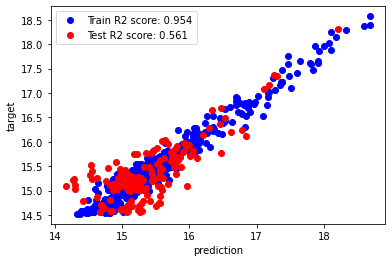

In [5]:
# training
print("start training", flush=True)
trained_encoder, trained_decoder, trained_property_network = train_model(
    vae_encoder=encoder,
    vae_decoder=decoder,
    property_network=property_network,
    x_train=x_train,
    x_test=x_test,
    y_train=y_with_feature_train,
    y_test=y_with_feature_test,
    num_epochs=500,
    batch_size=32,
    lr_enc=0.001,
    lr_dec=0.001,
    lr_property=0.001,
    KLD_alpha=1e-6,
    sample_num=1000,
    dtype=dtype,
    device=device,
    save_file_name='C_1000.png',
    scaler_list=scaler_list
)

In [6]:
# save vae
trained_vae = TrainedVAE(
    encoder=trained_encoder,
    decoder=trained_decoder,
    property_network=trained_property_network,
    scaler_list=scaler_list,
    scaler_key=y_with_feature.columns.tolist()
)
torch.save(trained_vae, 'vae/trained_vae/trained_C_500.pth')

### 2. Get reduced (16-dimensional) feature vectors using principal analysis

In [7]:
# principal analysis
with torch.no_grad():
    trained_vae = torch.load('vae/trained_vae/trained_C_500.pth')
    total_inp_flat_one_hot = x_data.flatten(start_dim=1)  # [b, 32*2]
    total_latent_points, mus, log_vars = trained_vae.encoder(total_inp_flat_one_hot)  # [b, latent_dimension]

    # principal component analysis
    n_components = 16
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(total_latent_points)
    principal_df = pd.DataFrame(
        data=principal_components,
        columns=['principal_component_%d' % (num + 1) for num in range(n_components)]
    )

    final_df = pd.concat([principal_df, y_with_feature[['lamellar_period', 'interaction_parameter']]], axis=1)
    final_df.to_csv('datasetC_principal_component_analysis_epochs_500.csv')

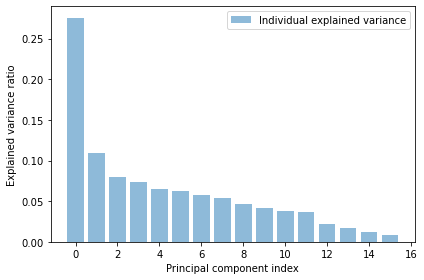

In [8]:
# plot explained variance by principal component analysis
exp_var_pca = pca.explained_variance_ratio_

plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',
        label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

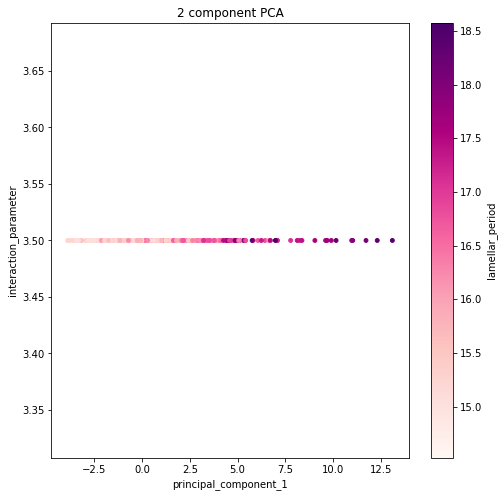

In [9]:
# plot
# x-component (1) principal component 1
# y-component (2) interaction parameter
# z-component (3) lamellar period

plot_two_pairs_color_map(
    x_list=final_df['principal_component_1'].values.tolist(),
    y_list=final_df['interaction_parameter'].values.tolist(),
    z_list=final_df['lamellar_period'].values.tolist(),
    x_name='principal_component_1',
    y_name='interaction_parameter',
    z_name='lamellar_period',
    title='2 component PCA'
)